In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import os
import datetime

start_time = datetime.datetime.now() 
print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2024-06-15 01:56:31.177618


# Ensure you have a graphics card, otherwise the training time will be excessively long

In [2]:
device = torch.device("cuda:1")
print(torch.cuda.is_available())

True


# Set fixed random seed to ensure reproducible results

In [3]:
def set_seed(seed):
    # --- Set random seed
    random.seed(seed)
    np.random.seed(seed)
    # --- Ensure consistency in hash behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    # --- Setting the workspace configuration of cuBLAS
    """
    By setting the workspace configuration of cuBLAS, 
    specific workspace sizes and algorithm combinations are ensured when running deep learning models, 
    thereby maintaining consistency of results.
    """
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # --- Make the random numbers generated on the CPU repeatable
    torch.manual_seed(seed)
    # --- Make the random numbers generated on a single GPU repeatable
    torch.cuda.manual_seed(seed)
    # --- Make the random numbers generated on multiple GPUs repeatable
    torch.cuda.manual_seed_all(seed)
    # --- Using deterministic algorithms ensures consistency and repeatability of calculation results across different runs
    torch.use_deterministic_algorithms(True)
    # --- Set the cuDNN backend to deterministic mode to ensure the use of deterministic algorithms
    """
    Certain operations (such as convolution) produce the same result in multiple runs.
    """
    torch.backends.cudnn.deterministic = True
    # --- Disable cuDNN using non deterministic algorithms
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

set_seed(2024)

# Define a function for calculating accuracy

In [4]:
def get_clean_acc(model, data_loader, model_device):
    model.eval()
    correct = 0
    total = 0
    
    for data, labels in data_loader:
        data, labels = data.to(model_device), labels.to(model_device)
        with torch.no_grad():
            logits = model(data)
            prediction = torch.argmax(logits, 1)
            ground_truth = labels
            total += labels.size(0)
            correct += (prediction == ground_truth).sum().item()
            
    accuracy = correct / total
    print(f"Total:{total}  Correct:{correct}  CleanAccuracy:{accuracy:.4f}")
    return accuracy

# Define a function for training the model

In [5]:
def train(model_device,
          model,
          model_optimizer, 
          train_set, validate_set,
          epochs=200,
          classes=["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
         ):
    train_loss_list = []
    validate_loss_list = []
    best_acc = -np.Inf
    
    # --- Define Scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=model_optimizer, milestones=[60, 120, 180], last_epoch=0 - 1)
    
    # --- Train
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        validate_loss = 0.0
        model.train()
        count = 0
        for dataset_train, dataset_train_labels in train_set:
            count = count + 1
            dataset_train, dataset_train_labels = dataset_train.to(model_device), dataset_train_labels.to(model_device)
            
            logits = model(dataset_train)

            model_optimizer.zero_grad()
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_train_labels)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            torch.cuda.empty_cache()
        train_loss_list.append(train_loss / count)
        if scheduler is not None:
            scheduler.step()
        
        # --- Validate
        model.eval()
        count = 0
        for dataset_validate, dataset_validate_labels in validate_set:
            count = count + 1
            dataset_validate, dataset_validate_labels = dataset_validate.to(model_device), dataset_validate_labels.to(model_device)

            with torch.no_grad():
                logits = model(dataset_validate)
            loss = nn.CrossEntropyLoss(reduction="mean")(logits, dataset_validate_labels)

            validate_loss += loss.item()
            torch.cuda.empty_cache()
        validate_loss_list.append(validate_loss / count)
        
        # --- Show results
        model.eval()
        end_time = datetime.datetime.now()
        time = end_time - start_time
        print(f"Epoch:{epoch}\nTime:{time}\nLoss:{validate_loss / count}")           
        acc = get_clean_acc(model, validate_set, model_device)
        torch.cuda.empty_cache()
        
        # --- Save best model parameters
        if not os.path.exists("./best_params/cifar10/vit_tiny"):
            os.makedirs("./best_params/cifar10/vit_tiny")
        if acc >= best_acc:
            path = os.path.join("./best_params/cifar10/vit_tiny", f"vit_tiny_params_{epoch}.pth")
            #torch.save(model.module.state_dict(), path)   # Enable during multi-GPUs training
            torch.save(model.state_dict(), path)           # Enable during single GPU training
            best_acc = acc
       
        # --- Visualize loss
        if epoch != 0:
            fig = plt.figure(figsize=(5, 5))
            x = range(0, len(validate_loss_list))
            y1 = train_loss_list
            y2 = validate_loss_list
            plt.plot(x, y1, label="Train Loss")
            plt.plot(x, y2, label="Validate Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            if not os.path.exists("./best_params/cifar10/vit_tiny/loss_curve"):
                os.makedirs("./best_params/cifar10/vit_tiny/loss_curve")
            path = os.path.join("./best_params/cifar10/vit_tiny/loss_curve", f"loss_curve_{epoch}.png")
            plt.savefig(path, bbox_inches='tight', dpi=500)
            plt.show()

# Load the dataset

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode="edge"),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.CIFAR10(root="./data",
                                         train=True,
                                         transform=transform_train,
                                         download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)

test_set = torchvision.datasets.CIFAR10(root="./data",
                                        train=False,
                                        transform=transform_test,
                                        download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1)
 
print("size=", len(train_loader))
print("size=", len(test_loader))

Files already downloaded and verified
Files already downloaded and verified
size= 1563
size= 313


# Load the model

In [7]:
from model_zoo.ViT import ViT_tiny_cifar10
net = ViT_tiny_cifar10()
net = net.to(device)

# Define Optimizer

In [8]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Begin to train

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch:0
Time:0:03:43.743908
Loss:1.7453880431933906


  0%|▍                                                                             | 1/200 [03:51<12:46:51, 231.21s/it]

Total:10000  Correct:3401  CleanAccuracy:0.3401
Epoch:1
Time:0:07:19.805730
Loss:1.7729800524422155
Total:10000  Correct:3391  CleanAccuracy:0.3391


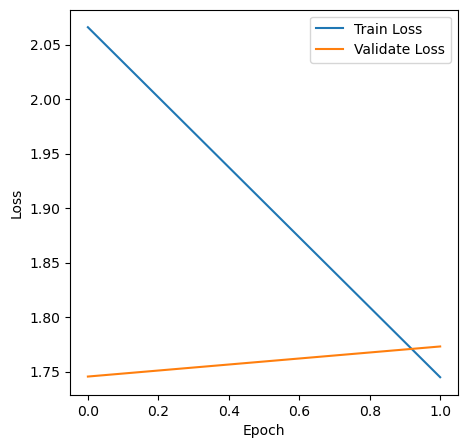

  1%|▊                                                                             | 2/200 [07:27<12:14:32, 222.59s/it]

Epoch:2
Time:0:11:01.047621
Loss:1.5824346698511143
Total:10000  Correct:4108  CleanAccuracy:0.4108


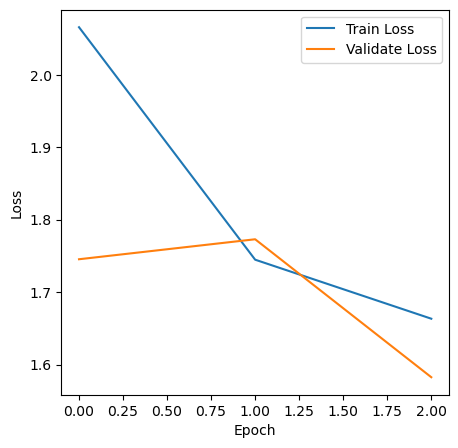

  2%|█▏                                                                            | 3/200 [11:09<12:09:06, 222.06s/it]

Epoch:3
Time:0:14:38.590793
Loss:1.5311691292558616
Total:10000  Correct:4244  CleanAccuracy:0.4244


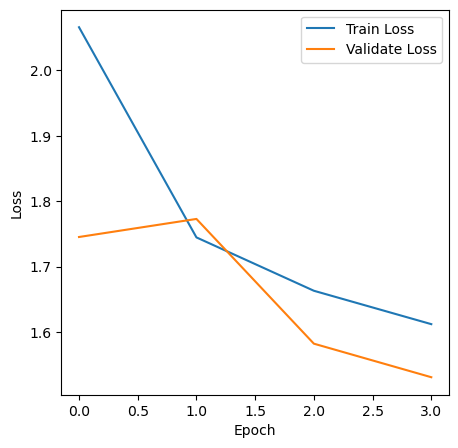

  2%|█▌                                                                            | 4/200 [14:46<11:59:31, 220.26s/it]

Epoch:4
Time:0:18:16.212501
Loss:1.803202239088357
Total:10000  Correct:3695  CleanAccuracy:0.3695


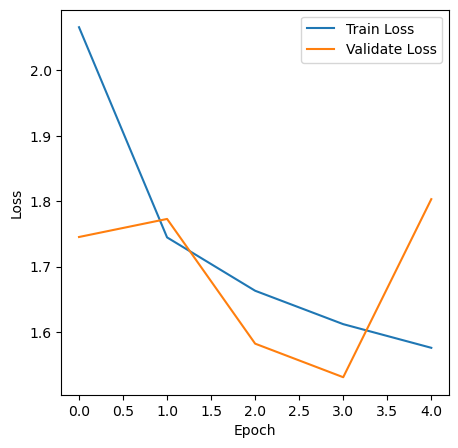

  2%|█▉                                                                            | 5/200 [18:23<11:52:12, 219.14s/it]

Epoch:5
Time:0:21:52.739838
Loss:1.7007746867859326
Total:10000  Correct:3954  CleanAccuracy:0.3954


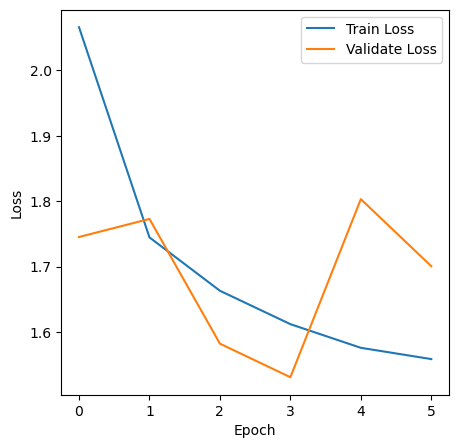

  3%|██▎                                                                           | 6/200 [21:59<11:45:01, 218.05s/it]

Epoch:6
Time:0:25:28.563930
Loss:1.5999360861488805
Total:10000  Correct:4185  CleanAccuracy:0.4185


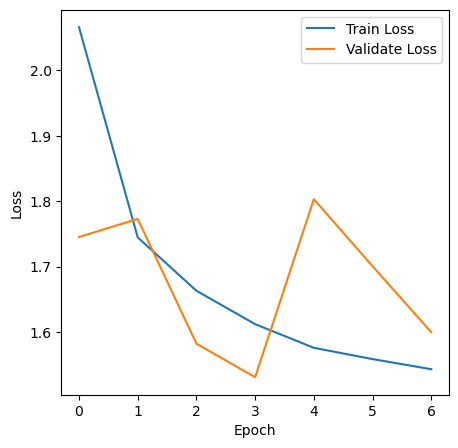

  4%|██▋                                                                           | 7/200 [25:36<11:40:23, 217.74s/it]

Epoch:7
Time:0:29:08.324903
Loss:1.5504011506089768
Total:10000  Correct:4267  CleanAccuracy:0.4267


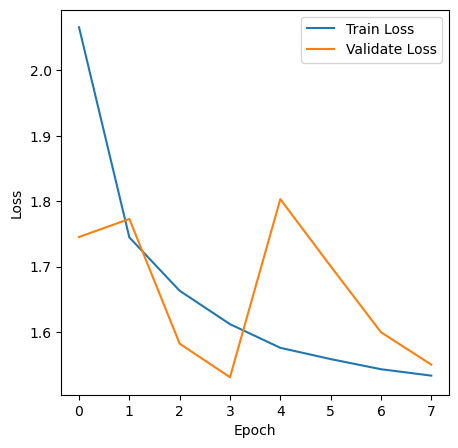

  4%|███                                                                           | 8/200 [29:16<11:38:31, 218.29s/it]

Epoch:8
Time:0:32:45.207219
Loss:1.5787352704392454
Total:10000  Correct:4283  CleanAccuracy:0.4283


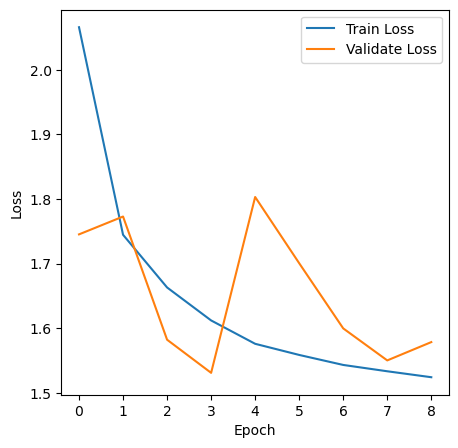

  4%|███▌                                                                          | 9/200 [32:53<11:33:36, 217.89s/it]

Epoch:9
Time:0:36:21.224978
Loss:1.6462461917925948
Total:10000  Correct:4004  CleanAccuracy:0.4004


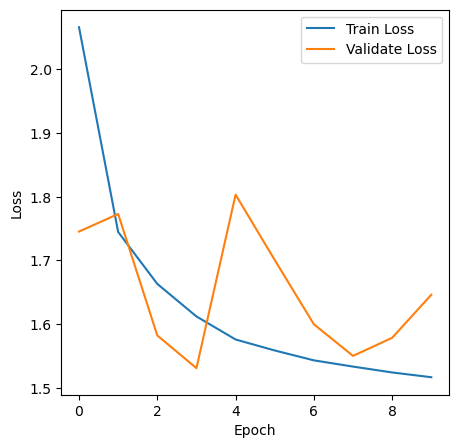

  5%|███▊                                                                         | 10/200 [36:29<11:27:55, 217.24s/it]

Epoch:10
Time:0:39:58.232030
Loss:1.5966622189591868
Total:10000  Correct:4262  CleanAccuracy:0.4262


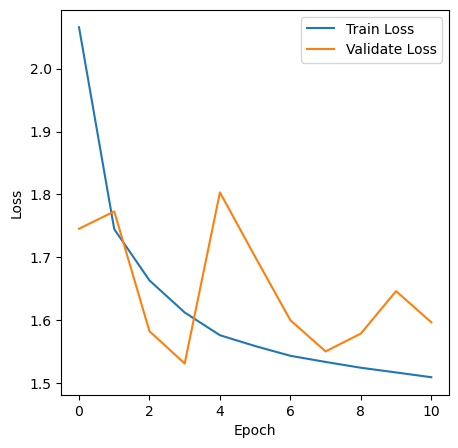

  6%|████▏                                                                        | 11/200 [40:06<11:24:02, 217.15s/it]

Epoch:11
Time:0:43:34.754631
Loss:1.4211237699079056
Total:10000  Correct:4880  CleanAccuracy:0.4880


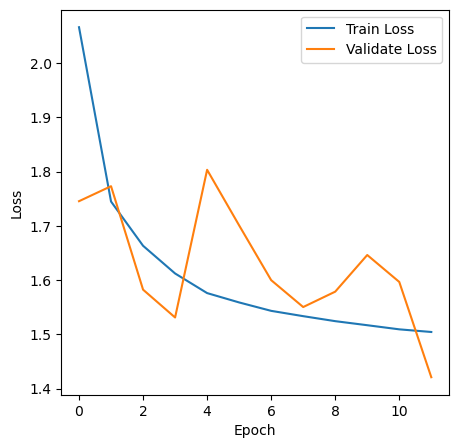

  6%|████▌                                                                        | 12/200 [43:42<11:19:56, 217.01s/it]

Epoch:12
Time:0:47:11.606827
Loss:1.4313466240422794
Total:10000  Correct:4627  CleanAccuracy:0.4627


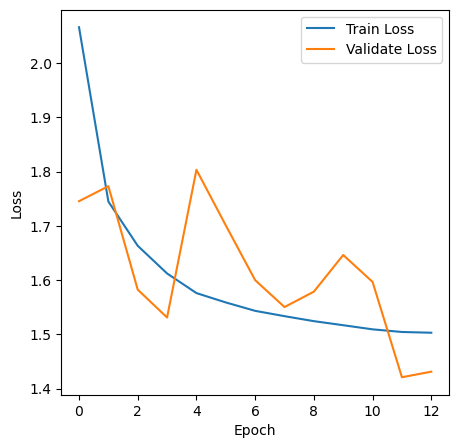

  6%|█████                                                                        | 13/200 [47:19<11:16:04, 216.92s/it]

Epoch:13
Time:0:50:47.625537
Loss:1.5393183067583809
Total:10000  Correct:4574  CleanAccuracy:0.4574


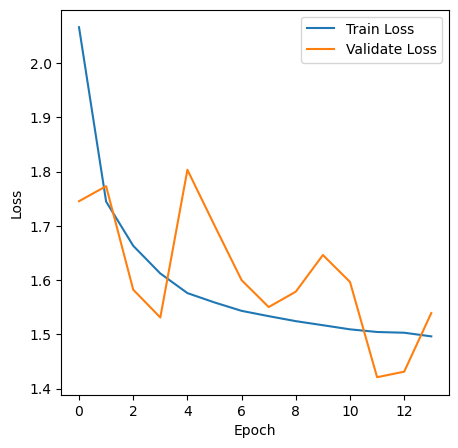

  7%|█████▍                                                                       | 14/200 [50:55<11:11:38, 216.66s/it]

Epoch:14
Time:0:54:25.227500
Loss:1.536288837845714
Total:10000  Correct:4480  CleanAccuracy:0.4480


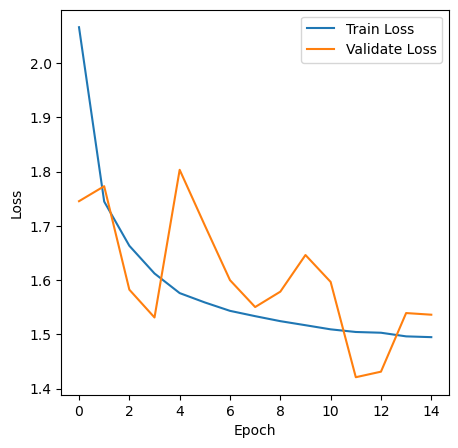

  8%|█████▊                                                                       | 15/200 [54:33<11:09:06, 217.01s/it]

Epoch:15
Time:0:58:02.132078
Loss:1.512568946082752
Total:10000  Correct:4339  CleanAccuracy:0.4339


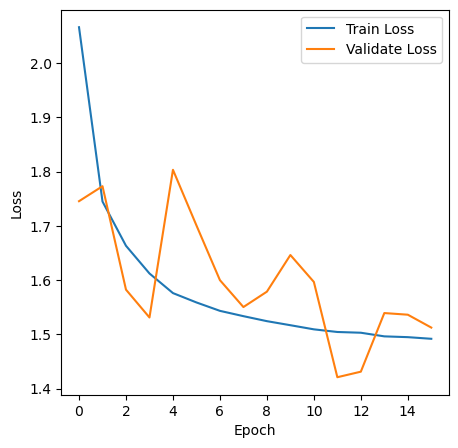

  8%|██████▏                                                                      | 16/200 [58:09<11:04:31, 216.70s/it]

Epoch:16
Time:1:01:37.859735
Loss:1.4651896466081515
Total:10000  Correct:4687  CleanAccuracy:0.4687


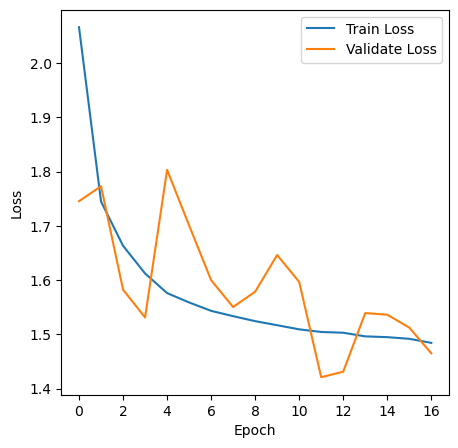

  8%|██████▍                                                                    | 17/200 [1:01:45<11:00:39, 216.61s/it]

Epoch:17
Time:1:05:14.133669
Loss:1.4675112263844037
Total:10000  Correct:4773  CleanAccuracy:0.4773


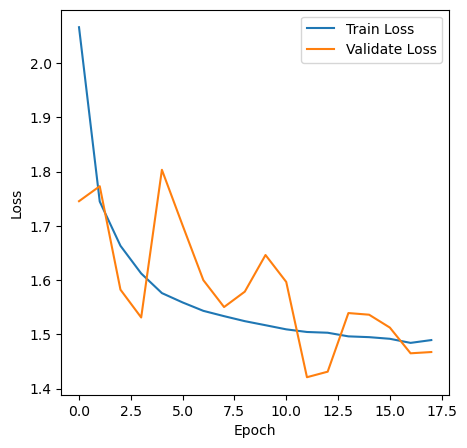

  9%|██████▊                                                                    | 18/200 [1:05:22<10:56:47, 216.52s/it]

Epoch:18
Time:1:08:51.019140
Loss:1.381422749342629
Total:10000  Correct:4933  CleanAccuracy:0.4933


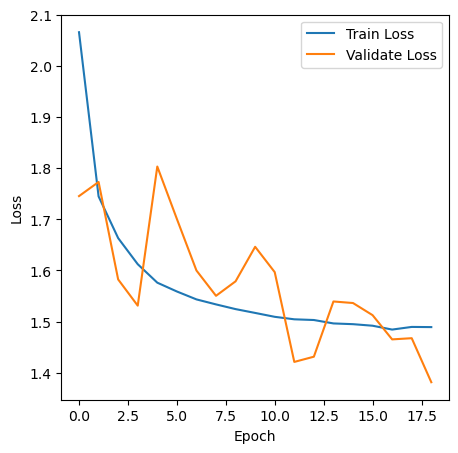

 10%|███████▏                                                                   | 19/200 [1:08:59<10:53:36, 216.67s/it]

Epoch:19
Time:1:12:30.870976
Loss:1.4632763158018216
Total:10000  Correct:4546  CleanAccuracy:0.4546


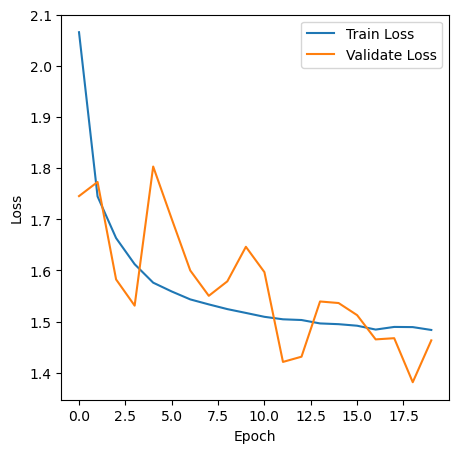

 10%|███████▌                                                                   | 20/200 [1:12:38<10:52:52, 217.63s/it]

Epoch:20
Time:1:16:07.911089
Loss:1.5515069003684072
Total:10000  Correct:4336  CleanAccuracy:0.4336


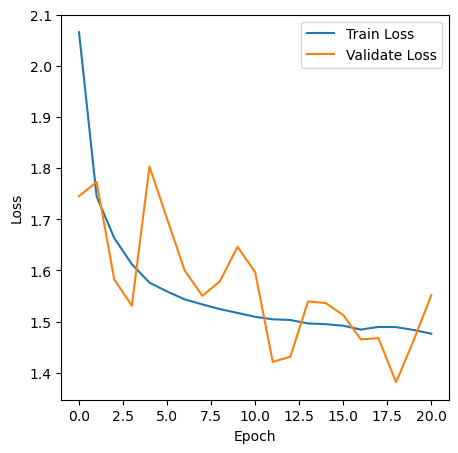

 10%|███████▉                                                                   | 21/200 [1:16:15<10:48:37, 217.42s/it]

Epoch:21
Time:1:19:45.103856
Loss:1.397657281674516
Total:10000  Correct:4795  CleanAccuracy:0.4795


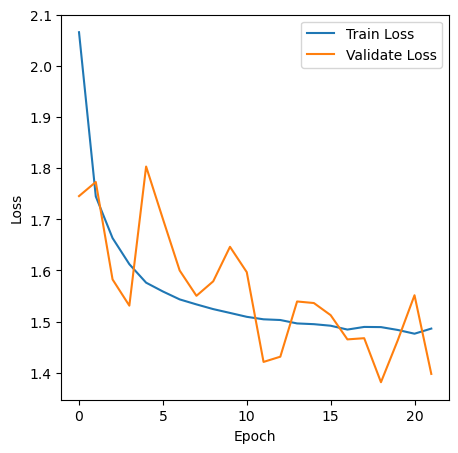

 11%|████████▎                                                                  | 22/200 [1:19:53<10:44:44, 217.33s/it]

Epoch:22
Time:1:23:21.849084
Loss:1.5077552641161716
Total:10000  Correct:4561  CleanAccuracy:0.4561


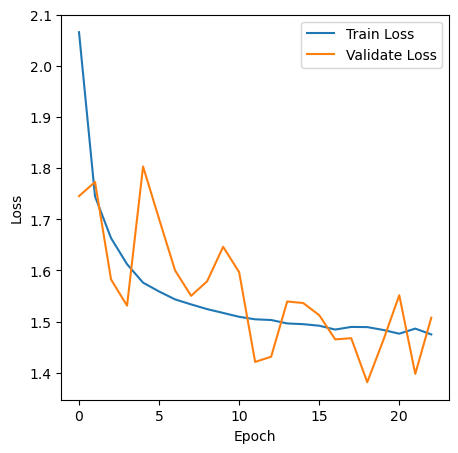

 12%|████████▋                                                                  | 23/200 [1:23:29<10:40:42, 217.19s/it]

Epoch:23
Time:1:26:58.515834
Loss:1.5701275934426548
Total:10000  Correct:4219  CleanAccuracy:0.4219


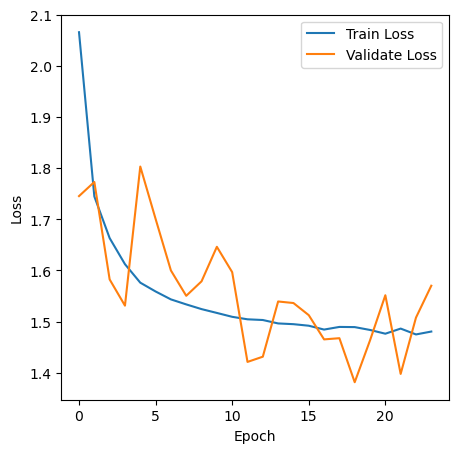

 12%|█████████                                                                  | 24/200 [1:27:06<10:36:34, 217.02s/it]

Epoch:24
Time:1:30:35.361075
Loss:1.4124463440511172
Total:10000  Correct:4817  CleanAccuracy:0.4817


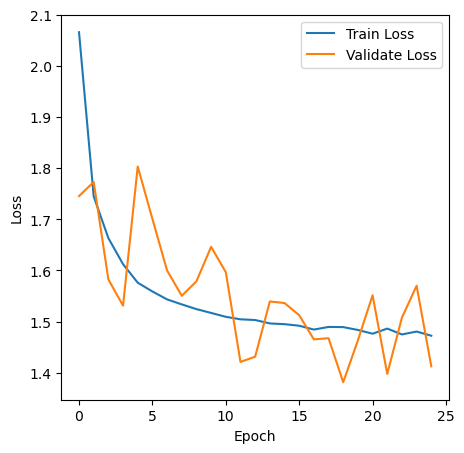

 12%|█████████▍                                                                 | 25/200 [1:30:43<10:32:49, 216.97s/it]

Epoch:25
Time:1:34:12.611921
Loss:1.4753359975144504
Total:10000  Correct:4585  CleanAccuracy:0.4585


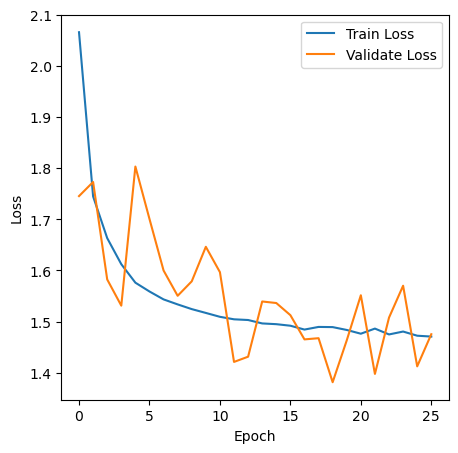

 13%|█████████▊                                                                 | 26/200 [1:34:20<10:29:20, 217.01s/it]

Epoch:26
Time:1:37:47.916051
Loss:1.4083035712044079
Total:10000  Correct:4952  CleanAccuracy:0.4952


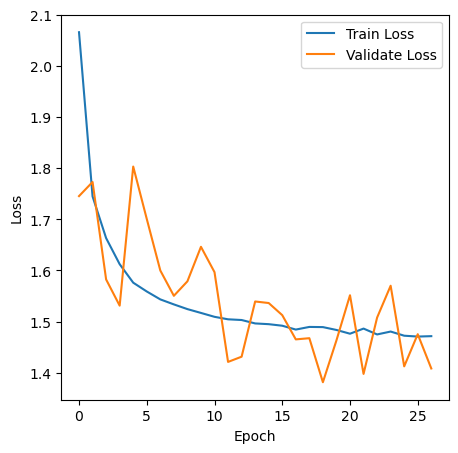

 14%|██████████▏                                                                | 27/200 [1:37:55<10:23:59, 216.41s/it]

Epoch:27
Time:1:41:24.543300
Loss:1.5068687539511976
Total:10000  Correct:4650  CleanAccuracy:0.4650


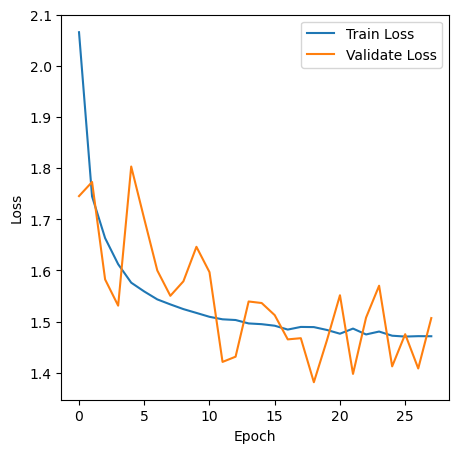

 14%|██████████▌                                                                | 28/200 [1:41:31<10:20:24, 216.42s/it]

Epoch:28
Time:1:45:02.618043
Loss:1.4366776276701174
Total:10000  Correct:4810  CleanAccuracy:0.4810


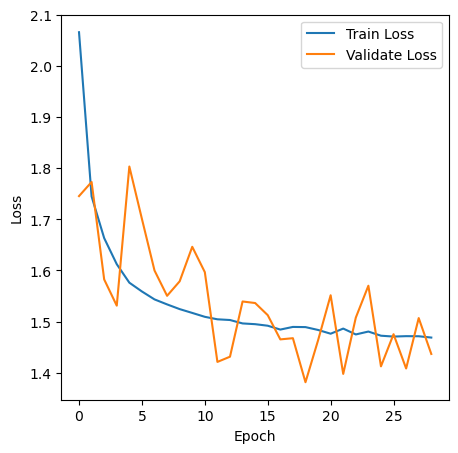

 14%|██████████▉                                                                | 29/200 [1:45:10<10:18:40, 217.08s/it]

Epoch:29
Time:1:48:39.054364
Loss:1.4026167621246923
Total:10000  Correct:4956  CleanAccuracy:0.4956


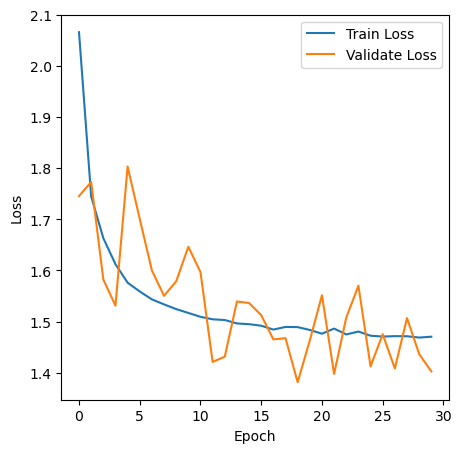

 15%|███████████▎                                                               | 30/200 [1:48:46<10:14:32, 216.90s/it]

Epoch:30
Time:1:52:15.104090
Loss:1.4146759167265968
Total:10000  Correct:4716  CleanAccuracy:0.4716


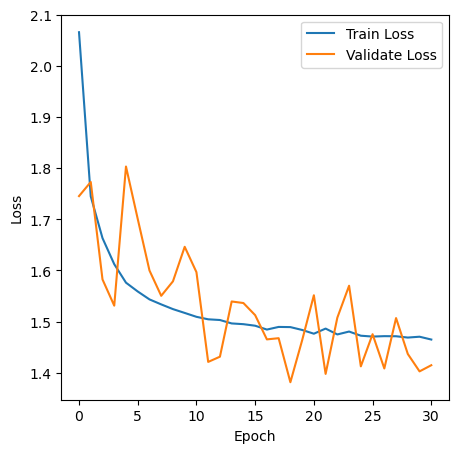

 16%|███████████▋                                                               | 31/200 [1:52:23<10:10:20, 216.69s/it]

Epoch:31
Time:1:55:52.830884
Loss:1.4818366091853132
Total:10000  Correct:4581  CleanAccuracy:0.4581


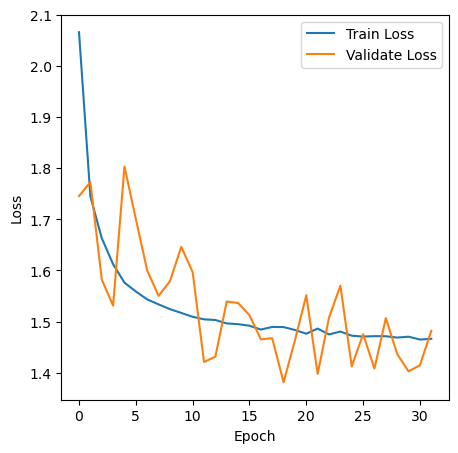

 16%|████████████                                                               | 32/200 [1:56:00<10:07:24, 216.93s/it]

Epoch:32
Time:1:59:29.848384
Loss:1.410208040152114
Total:10000  Correct:4865  CleanAccuracy:0.4865


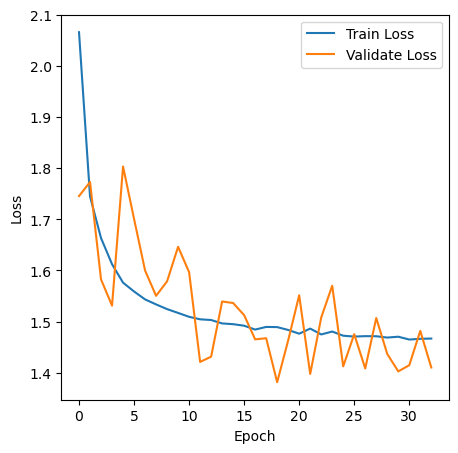

 16%|████████████▍                                                              | 33/200 [1:59:37<10:03:58, 217.00s/it]

Epoch:33
Time:2:03:06.979310
Loss:1.5344435829704943
Total:10000  Correct:4426  CleanAccuracy:0.4426


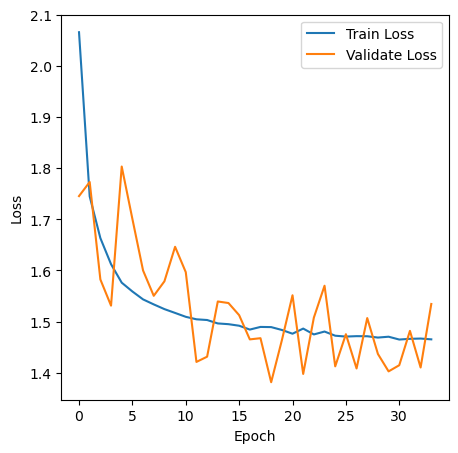

 17%|████████████▉                                                               | 34/200 [2:03:14<9:59:57, 216.85s/it]

Epoch:34
Time:2:06:44.433176
Loss:1.4450205328365484
Total:10000  Correct:4764  CleanAccuracy:0.4764


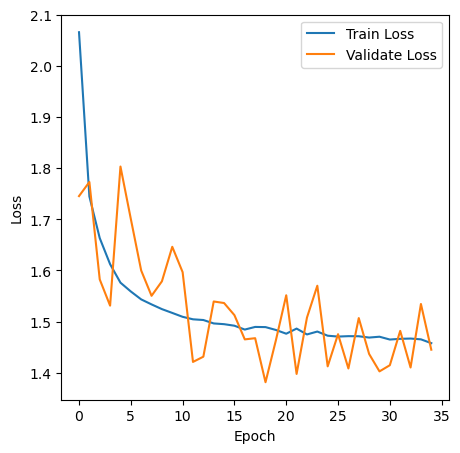

 18%|█████████████▎                                                              | 35/200 [2:06:52<9:57:13, 217.18s/it]

Epoch:35
Time:2:10:20.900292
Loss:1.4066642090535393
Total:10000  Correct:4903  CleanAccuracy:0.4903


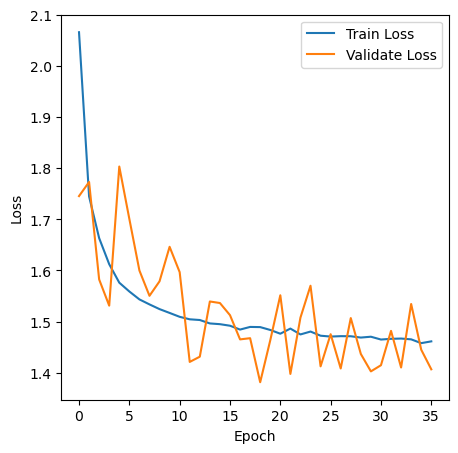

 18%|█████████████▋                                                              | 36/200 [2:10:28<9:53:01, 216.96s/it]

Epoch:36
Time:2:13:58.181664
Loss:1.4491518556881255
Total:10000  Correct:4742  CleanAccuracy:0.4742


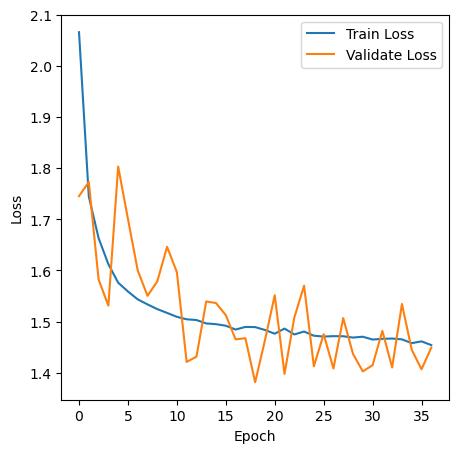

 18%|██████████████                                                              | 37/200 [2:14:06<9:49:47, 217.10s/it]

Epoch:37
Time:2:17:36.662598
Loss:1.4733122781442758
Total:10000  Correct:4602  CleanAccuracy:0.4602


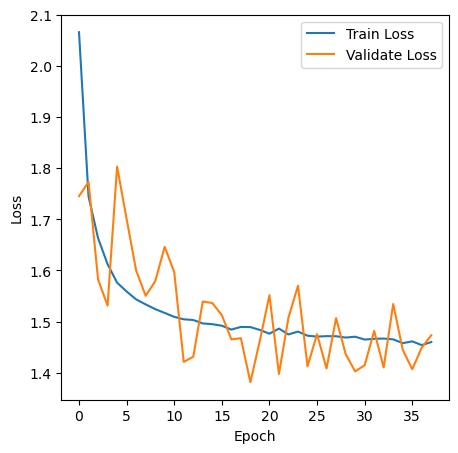

 19%|██████████████▍                                                             | 38/200 [2:17:44<9:47:03, 217.43s/it]

Epoch:38
Time:2:21:13.666756
Loss:1.4146346649803674
Total:10000  Correct:4853  CleanAccuracy:0.4853


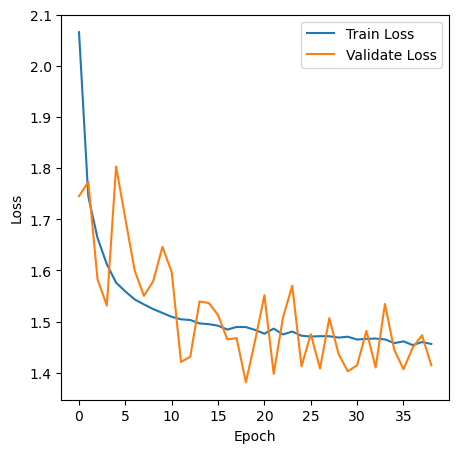

 20%|██████████████▊                                                             | 39/200 [2:21:21<9:42:54, 217.23s/it]

Epoch:39
Time:2:24:50.171216
Loss:1.4311132385327032
Total:10000  Correct:4884  CleanAccuracy:0.4884


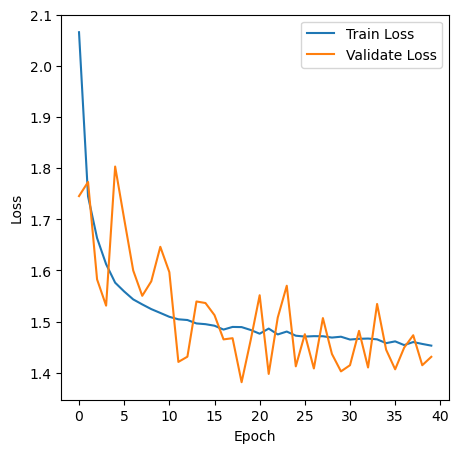

 20%|███████████████▏                                                            | 40/200 [2:24:58<9:39:11, 217.20s/it]

Epoch:40
Time:2:28:28.117441
Loss:1.5033222294082276
Total:10000  Correct:4619  CleanAccuracy:0.4619


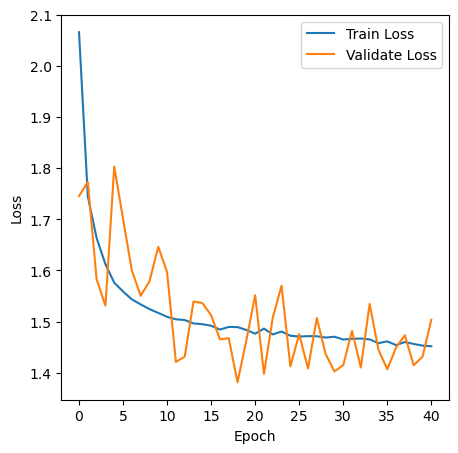

 20%|███████████████▌                                                            | 41/200 [2:28:36<9:36:04, 217.39s/it]

Epoch:41
Time:2:32:05.637524
Loss:1.4766961480862797
Total:10000  Correct:4576  CleanAccuracy:0.4576


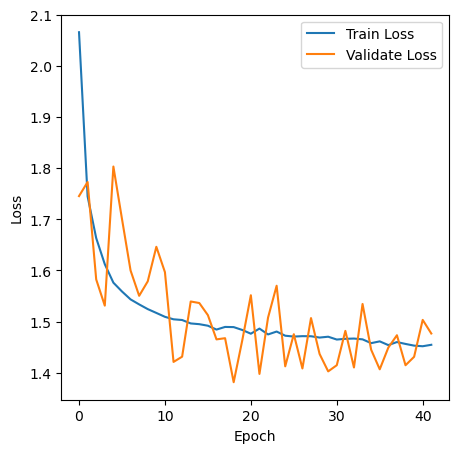

 21%|███████████████▉                                                            | 42/200 [2:32:13<9:32:30, 217.41s/it]

Epoch:42
Time:2:35:42.857513
Loss:1.4393067921693332
Total:10000  Correct:4827  CleanAccuracy:0.4827


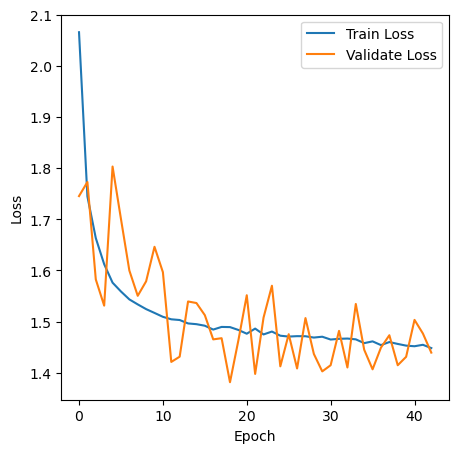

 22%|████████████████▎                                                           | 43/200 [2:35:50<9:28:52, 217.41s/it]

Epoch:43
Time:2:39:20.317185
Loss:1.4049327343035811
Total:10000  Correct:4928  CleanAccuracy:0.4928


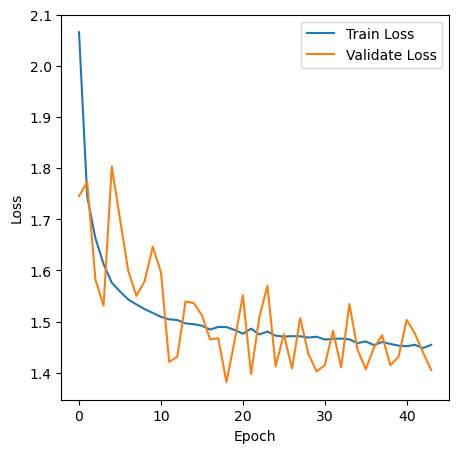

 22%|████████████████▋                                                           | 44/200 [2:39:28<9:25:05, 217.34s/it]

Epoch:44
Time:2:42:57.067786
Loss:1.401748993907112
Total:10000  Correct:4932  CleanAccuracy:0.4932


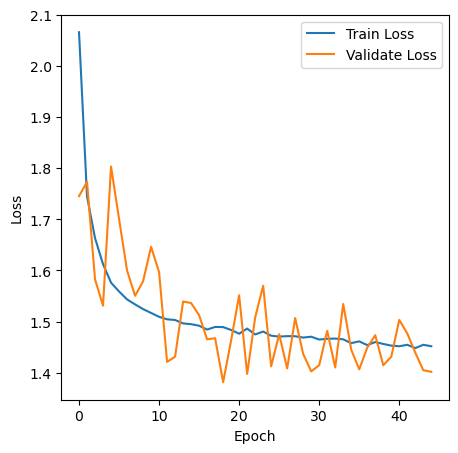

 22%|█████████████████                                                           | 45/200 [2:43:05<9:21:05, 217.20s/it]

Epoch:45
Time:2:46:33.034919
Loss:1.5447674791652934
Total:10000  Correct:4177  CleanAccuracy:0.4177


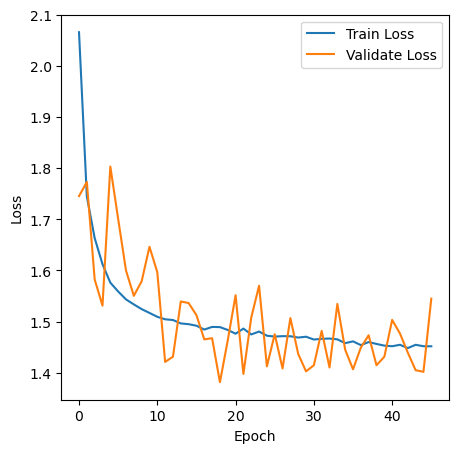

 23%|█████████████████▍                                                          | 46/200 [2:46:40<9:16:27, 216.80s/it]

Epoch:46
Time:2:50:09.098763
Loss:1.4104088942844646
Total:10000  Correct:4941  CleanAccuracy:0.4941


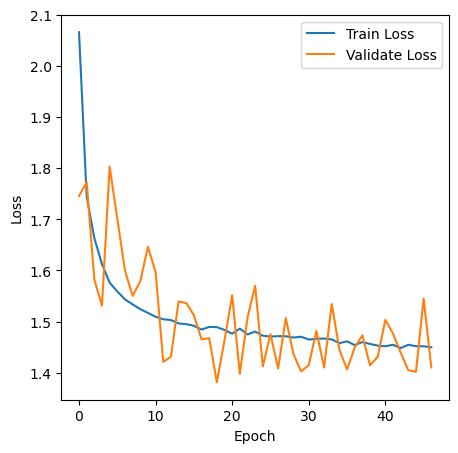

 24%|█████████████████▊                                                          | 47/200 [2:50:17<9:12:19, 216.60s/it]

Epoch:47
Time:2:53:44.861316
Loss:1.5248894973303944
Total:10000  Correct:4647  CleanAccuracy:0.4647


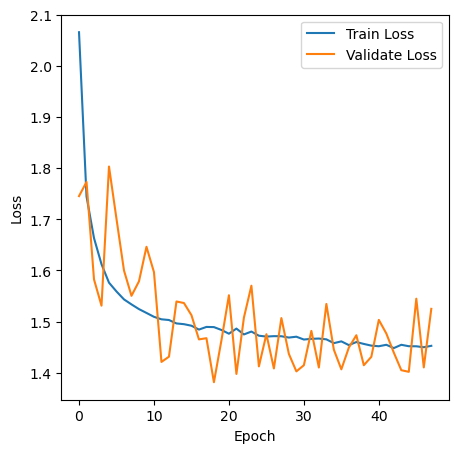

 24%|██████████████████▏                                                         | 48/200 [2:53:52<9:08:10, 216.39s/it]

Epoch:48
Time:2:57:22.526035
Loss:1.3618336108545908
Total:10000  Correct:5085  CleanAccuracy:0.5085


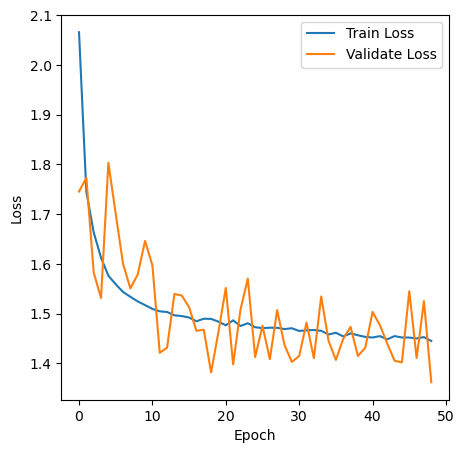

 24%|██████████████████▌                                                         | 49/200 [2:57:30<9:05:21, 216.70s/it]

Epoch:49
Time:3:01:00.115977
Loss:1.4545983719749573
Total:10000  Correct:4803  CleanAccuracy:0.4803


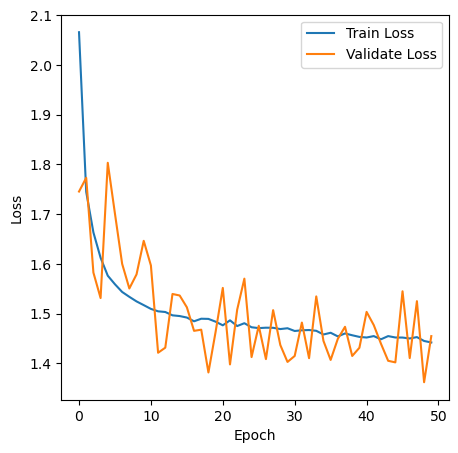

 25%|███████████████████                                                         | 50/200 [3:01:08<9:02:31, 217.01s/it]

Epoch:50
Time:3:04:36.369086
Loss:1.522149520941055
Total:10000  Correct:4598  CleanAccuracy:0.4598


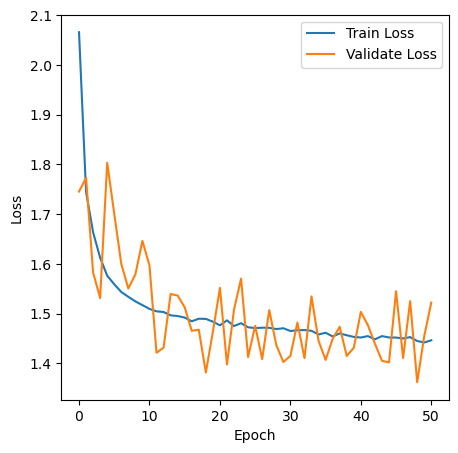

 26%|███████████████████▍                                                        | 51/200 [3:04:44<8:58:11, 216.72s/it]

Epoch:51
Time:3:08:13.758585
Loss:1.4020068609295562
Total:10000  Correct:4985  CleanAccuracy:0.4985


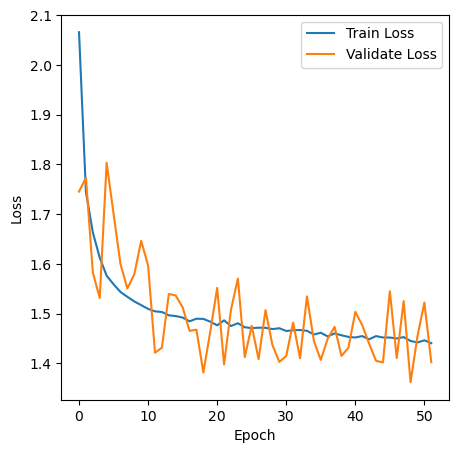

 26%|███████████████████▊                                                        | 52/200 [3:08:21<8:55:11, 216.97s/it]

Epoch:52
Time:3:11:50.406034
Loss:1.5613321187778022
Total:10000  Correct:4554  CleanAccuracy:0.4554


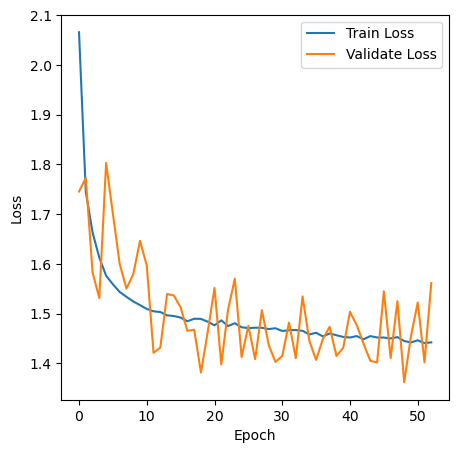

 26%|████████████████████▏                                                       | 53/200 [3:11:58<8:51:23, 216.89s/it]

Epoch:53
Time:3:15:27.811745
Loss:1.4492441878532067
Total:10000  Correct:4756  CleanAccuracy:0.4756


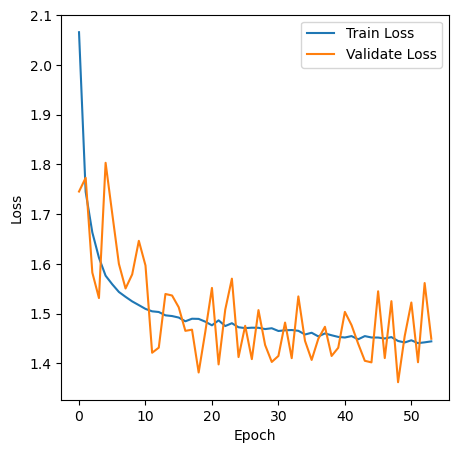

 27%|████████████████████▌                                                       | 54/200 [3:15:35<8:48:13, 217.08s/it]

Epoch:54
Time:3:19:05.373426
Loss:1.4347996612707266
Total:10000  Correct:4685  CleanAccuracy:0.4685


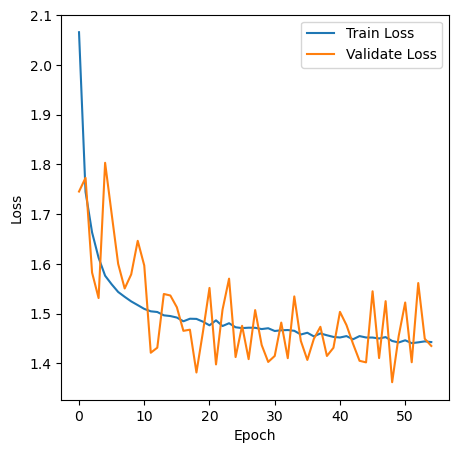

 28%|████████████████████▉                                                       | 55/200 [3:19:13<8:44:51, 217.18s/it]

Epoch:55
Time:3:22:43.646204
Loss:1.5507146668510314
Total:10000  Correct:4499  CleanAccuracy:0.4499


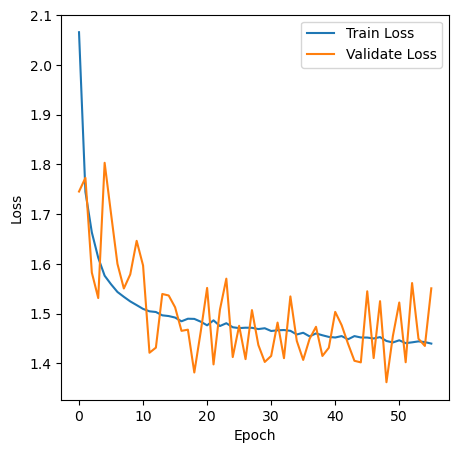

 28%|█████████████████████▎                                                      | 56/200 [3:22:51<8:42:05, 217.54s/it]

Epoch:56
Time:3:26:21.254534
Loss:1.6052095238773967
Total:10000  Correct:4131  CleanAccuracy:0.4131


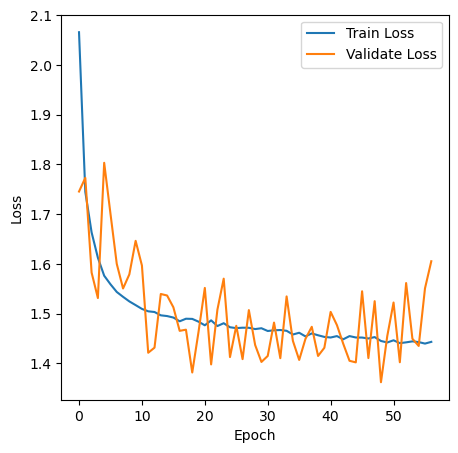

 28%|█████████████████████▋                                                      | 57/200 [3:26:29<8:38:26, 217.53s/it]

Epoch:57
Time:3:29:59.602182
Loss:1.5021803672321308
Total:10000  Correct:4431  CleanAccuracy:0.4431


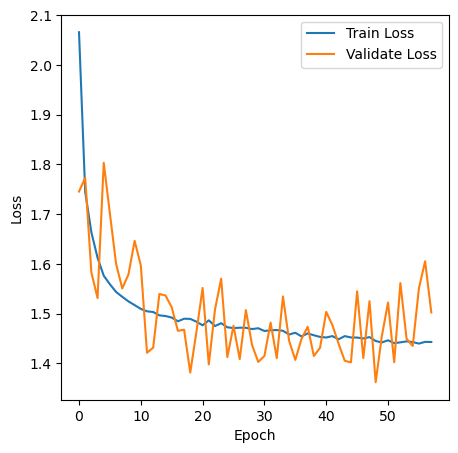

 29%|██████████████████████                                                      | 58/200 [3:30:07<8:35:24, 217.78s/it]

Epoch:58
Time:3:33:37.728363
Loss:1.367440234929228
Total:10000  Correct:5026  CleanAccuracy:0.5026


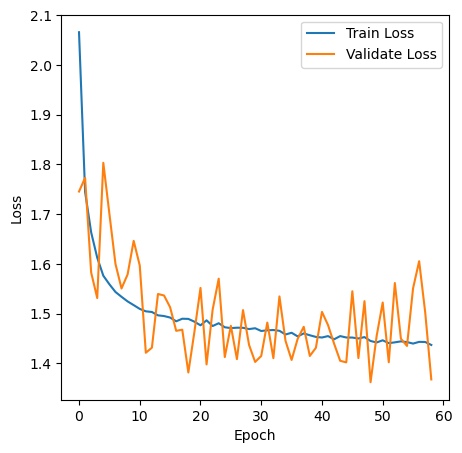

 30%|██████████████████████▍                                                     | 59/200 [3:33:45<8:32:00, 217.88s/it]

Epoch:59
Time:3:37:15.914511
Loss:1.4436668262314112
Total:10000  Correct:4684  CleanAccuracy:0.4684


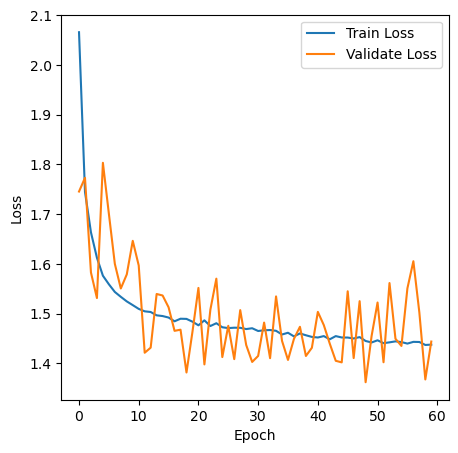

 30%|██████████████████████▊                                                     | 60/200 [3:37:23<8:28:10, 217.79s/it]

Epoch:60
Time:3:40:52.354785
Loss:1.1794912243803468
Total:10000  Correct:5762  CleanAccuracy:0.5762


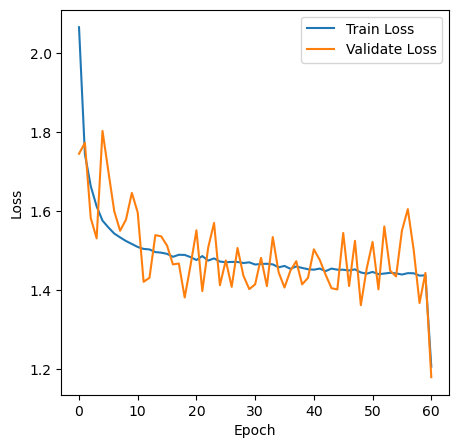

 30%|███████████████████████▏                                                    | 61/200 [3:41:00<8:24:06, 217.60s/it]

Epoch:61
Time:3:44:29.696477
Loss:1.1537092055756444
Total:10000  Correct:5853  CleanAccuracy:0.5853


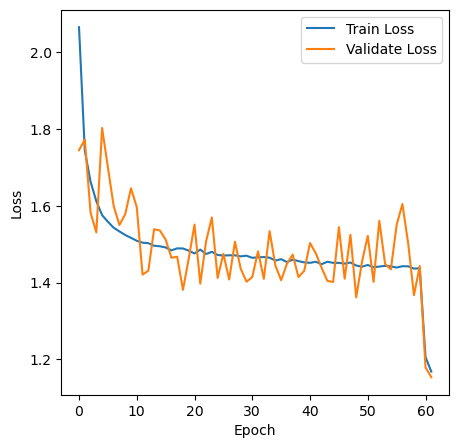

 31%|███████████████████████▌                                                    | 62/200 [3:44:36<8:19:46, 217.30s/it]

Epoch:62
Time:3:48:06.870476
Loss:1.1149965128578698
Total:10000  Correct:5994  CleanAccuracy:0.5994


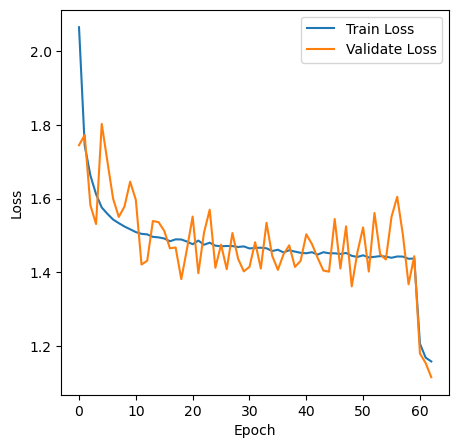

 32%|███████████████████████▉                                                    | 63/200 [3:48:14<8:16:29, 217.44s/it]

Epoch:63
Time:3:51:44.017027
Loss:1.1145923754658562
Total:10000  Correct:6037  CleanAccuracy:0.6037


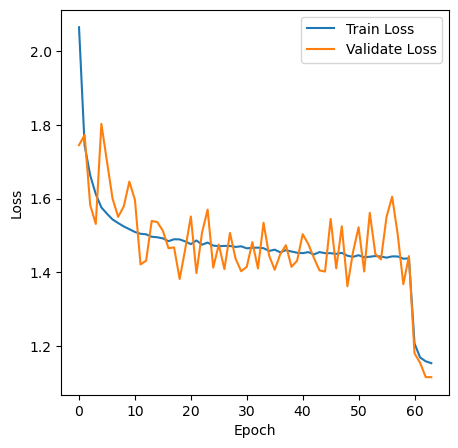

 32%|████████████████████████▎                                                   | 64/200 [3:51:52<8:12:47, 217.41s/it]

Epoch:64
Time:3:55:20.880173
Loss:1.1044718400358011
Total:10000  Correct:5983  CleanAccuracy:0.5983


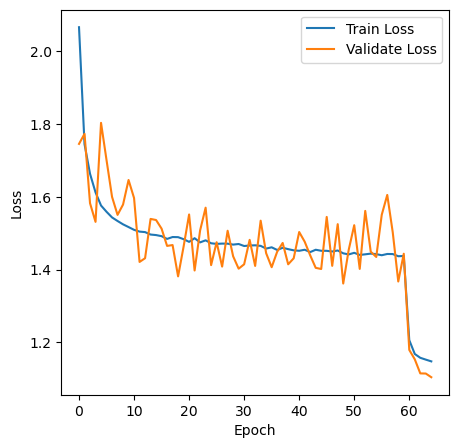

 32%|████████████████████████▋                                                   | 65/200 [3:55:28<8:08:47, 217.24s/it]

Epoch:65
Time:3:58:57.435962
Loss:1.12578540450087
Total:10000  Correct:5949  CleanAccuracy:0.5949


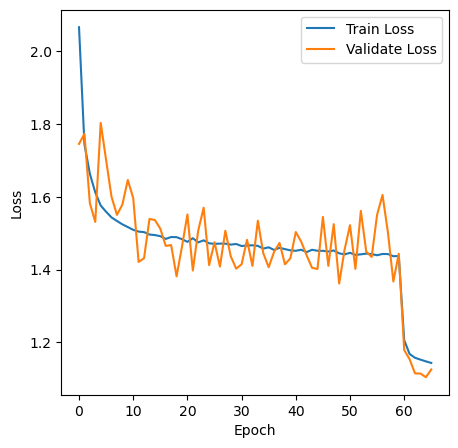

 33%|█████████████████████████                                                   | 66/200 [3:59:05<8:04:41, 217.03s/it]

Epoch:66
Time:4:02:35.214388
Loss:1.1234669035996874
Total:10000  Correct:5916  CleanAccuracy:0.5916


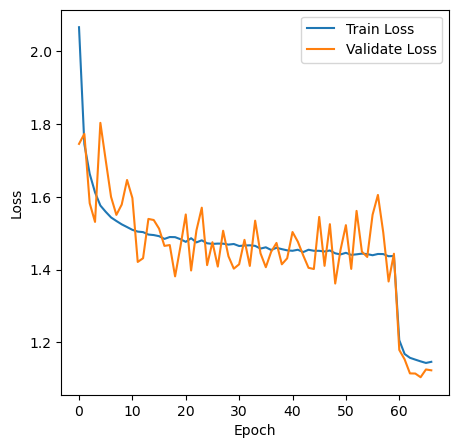

 34%|█████████████████████████▍                                                  | 67/200 [4:02:43<8:01:27, 217.20s/it]

Epoch:67
Time:4:06:12.393402
Loss:1.0835116869344499
Total:10000  Correct:6113  CleanAccuracy:0.6113


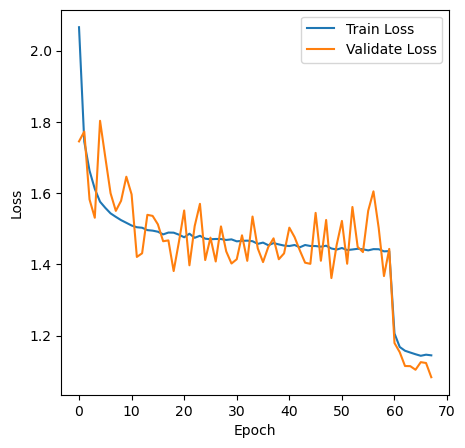

 34%|█████████████████████████▊                                                  | 68/200 [4:06:20<7:57:55, 217.24s/it]

Epoch:68
Time:4:09:50.574409
Loss:1.103490306736943
Total:10000  Correct:5968  CleanAccuracy:0.5968


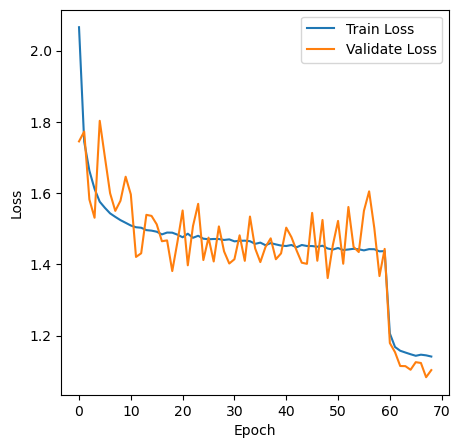

 34%|██████████████████████████▏                                                 | 69/200 [4:09:58<7:54:47, 217.46s/it]

Epoch:69
Time:4:13:27.803326
Loss:1.1238043399664541
Total:10000  Correct:5949  CleanAccuracy:0.5949


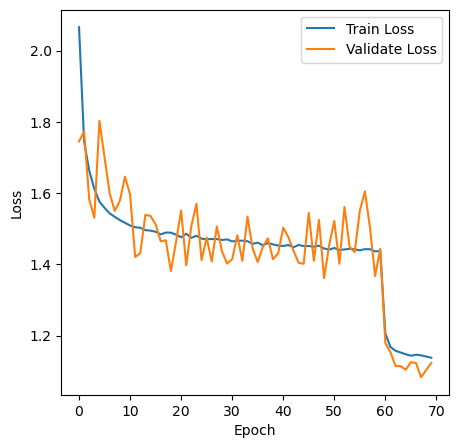

 35%|██████████████████████████▌                                                 | 70/200 [4:13:35<7:51:00, 217.39s/it]

Epoch:70
Time:4:17:05.609538
Loss:1.1086906122323423
Total:10000  Correct:5998  CleanAccuracy:0.5998


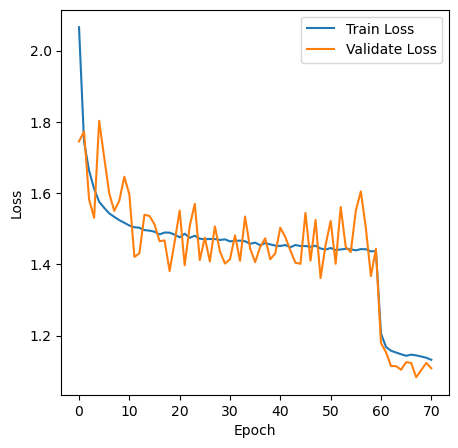

 36%|██████████████████████████▉                                                 | 71/200 [4:17:13<7:47:26, 217.41s/it]

Epoch:71
Time:4:20:43.330550
Loss:1.0984860630081104
Total:10000  Correct:6095  CleanAccuracy:0.6095


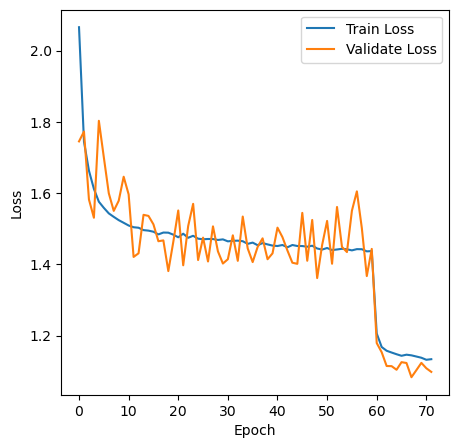

 36%|███████████████████████████▎                                                | 72/200 [4:20:50<7:43:49, 217.42s/it]

Epoch:72
Time:4:24:19.042590
Loss:1.1277046272168145
Total:10000  Correct:5935  CleanAccuracy:0.5935


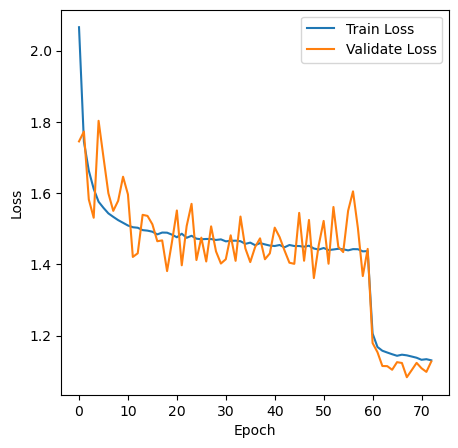

 36%|███████████████████████████▋                                                | 73/200 [4:24:27<7:39:38, 217.16s/it]

Epoch:73
Time:4:27:56.147313
Loss:1.0693322837162322
Total:10000  Correct:6112  CleanAccuracy:0.6112


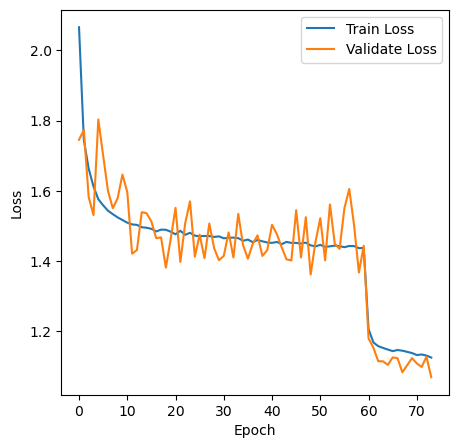

 37%|████████████████████████████                                                | 74/200 [4:28:03<7:35:53, 217.09s/it]

Epoch:74
Time:4:31:32.602323
Loss:1.0765363134134311
Total:10000  Correct:6086  CleanAccuracy:0.6086


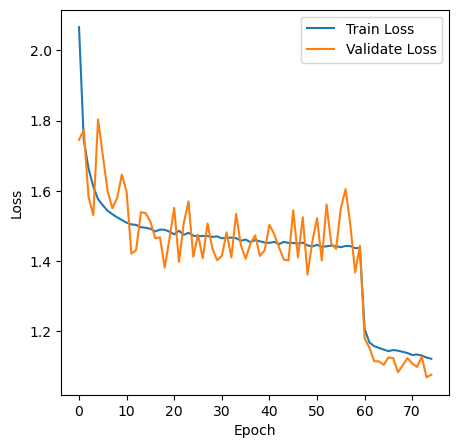

 38%|████████████████████████████▌                                               | 75/200 [4:31:40<7:31:53, 216.91s/it]

Epoch:75
Time:4:35:09.528600
Loss:1.061417369606396
Total:10000  Correct:6215  CleanAccuracy:0.6215


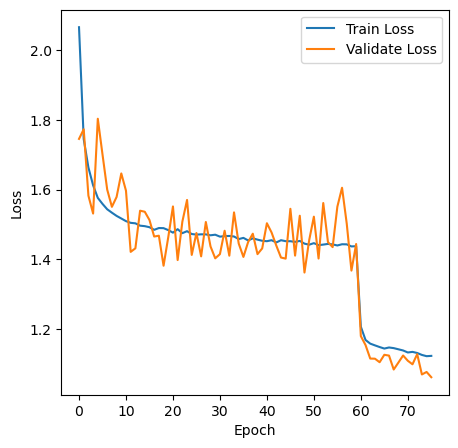

 38%|████████████████████████████▉                                               | 76/200 [4:35:17<7:28:20, 216.94s/it]

Epoch:76
Time:4:38:46.239987
Loss:1.0425736323332253
Total:10000  Correct:6241  CleanAccuracy:0.6241


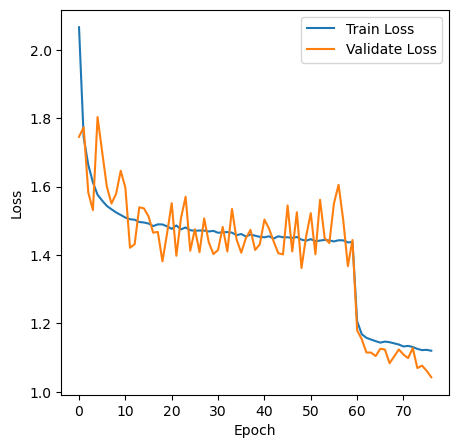

 38%|█████████████████████████████▎                                              | 77/200 [4:38:53<7:24:27, 216.81s/it]

Epoch:77
Time:4:42:22.150642
Loss:1.0530234594314625
Total:10000  Correct:6224  CleanAccuracy:0.6224


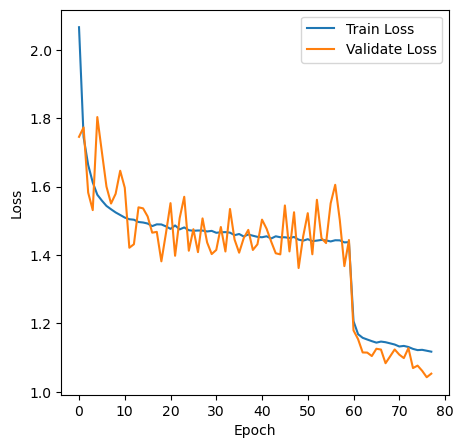

 39%|█████████████████████████████▋                                              | 78/200 [4:42:29<7:20:16, 216.53s/it]

Epoch:78
Time:4:45:58.245886
Loss:1.0598101653991796
Total:10000  Correct:6162  CleanAccuracy:0.6162


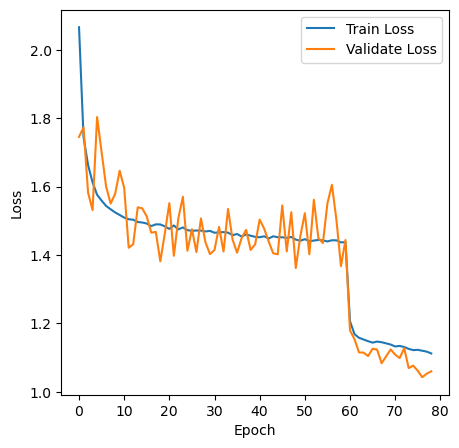

 40%|██████████████████████████████                                              | 79/200 [4:46:06<7:16:30, 216.45s/it]

Epoch:79
Time:4:49:35.410373
Loss:1.0575441177279805
Total:10000  Correct:6203  CleanAccuracy:0.6203


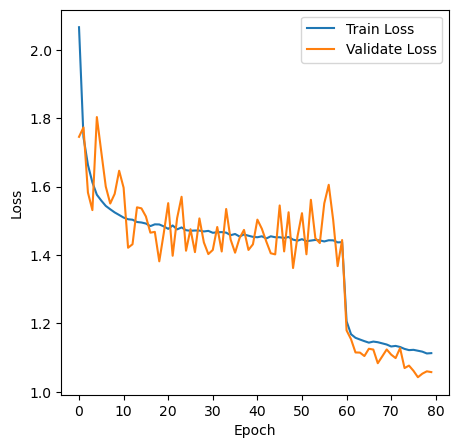

 40%|██████████████████████████████▍                                             | 80/200 [4:49:43<7:13:24, 216.70s/it]

Epoch:80
Time:4:53:12.117042
Loss:1.071752721699663
Total:10000  Correct:6162  CleanAccuracy:0.6162


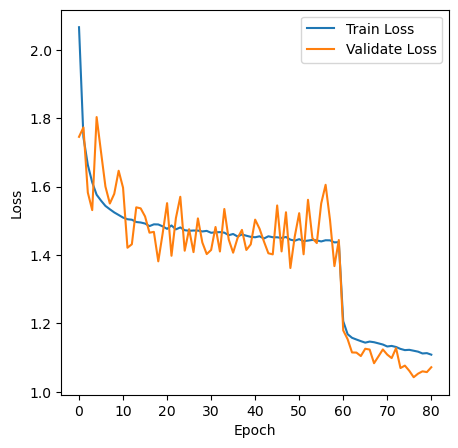

 40%|██████████████████████████████▊                                             | 81/200 [4:53:19<7:09:40, 216.65s/it]

Epoch:81
Time:4:56:49.889417
Loss:1.060077534316066
Total:10000  Correct:6126  CleanAccuracy:0.6126


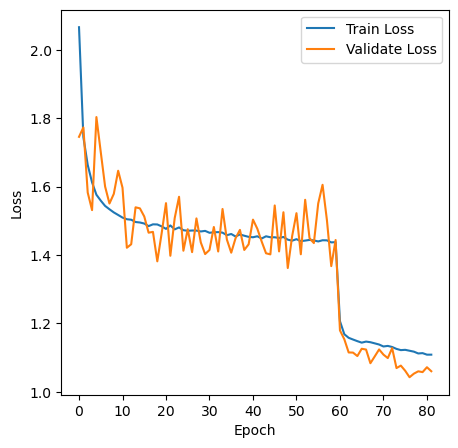

 41%|███████████████████████████████▏                                            | 82/200 [4:56:57<7:06:34, 216.90s/it]

Epoch:82
Time:5:00:27.295160
Loss:1.0536019015616882
Total:10000  Correct:6219  CleanAccuracy:0.6219


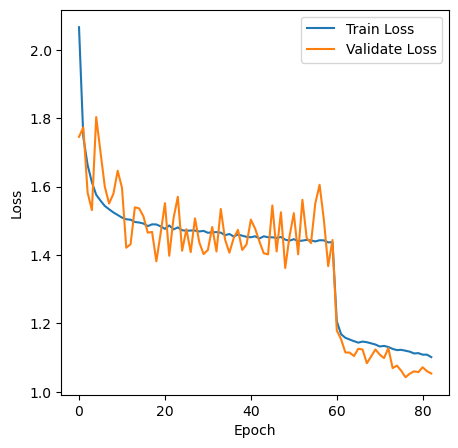

 42%|███████████████████████████████▌                                            | 83/200 [5:00:35<7:03:24, 217.13s/it]

Epoch:83
Time:5:04:05.237596
Loss:1.1085666018172193
Total:10000  Correct:6053  CleanAccuracy:0.6053


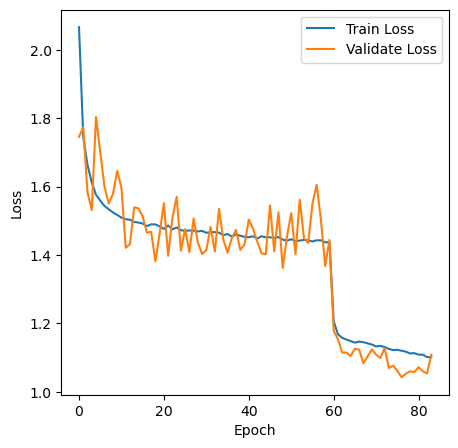

 42%|███████████████████████████████▉                                            | 84/200 [5:04:13<7:00:19, 217.41s/it]

Epoch:84
Time:5:07:42.634761
Loss:1.0934675890035903
Total:10000  Correct:6116  CleanAccuracy:0.6116


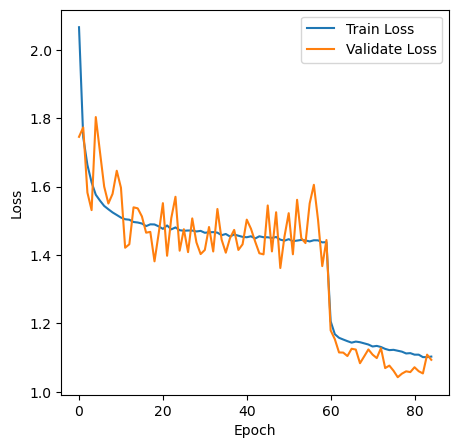

 42%|████████████████████████████████▎                                           | 85/200 [5:07:50<6:56:43, 217.43s/it]

Epoch:85
Time:5:11:20.838274
Loss:1.0873691085428476
Total:10000  Correct:6201  CleanAccuracy:0.6201


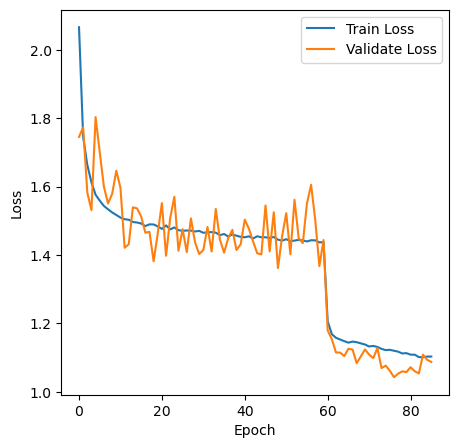

 43%|████████████████████████████████▋                                           | 86/200 [5:11:28<6:53:28, 217.62s/it]

Epoch:86
Time:5:14:57.979234
Loss:1.034286635561873
Total:10000  Correct:6272  CleanAccuracy:0.6272


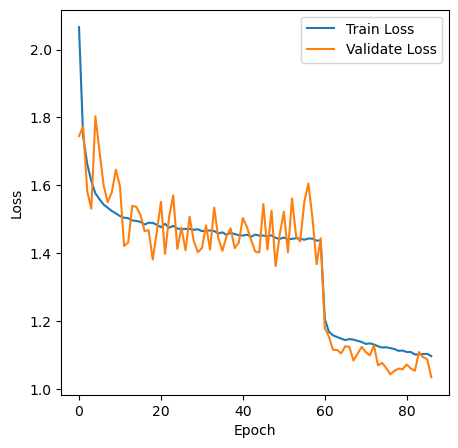

 44%|█████████████████████████████████                                           | 87/200 [5:15:05<6:49:35, 217.48s/it]

Epoch:87
Time:5:18:36.172057
Loss:1.0393166176427286
Total:10000  Correct:6258  CleanAccuracy:0.6258


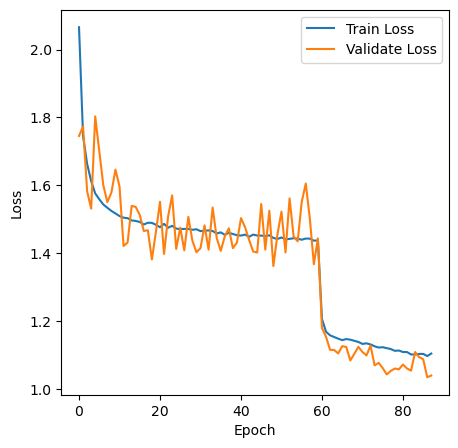

 44%|█████████████████████████████████▍                                          | 88/200 [5:18:44<6:46:25, 217.73s/it]

Epoch:88
Time:5:22:14.362876
Loss:1.105691143689445
Total:10000  Correct:6052  CleanAccuracy:0.6052


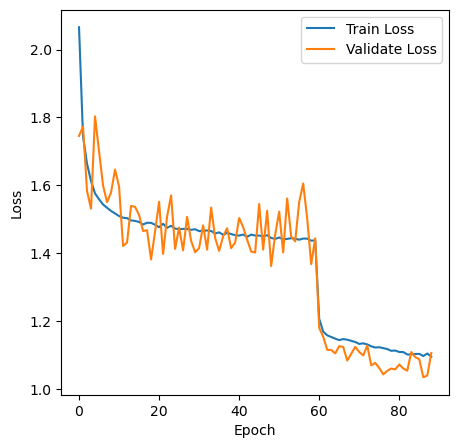

 44%|█████████████████████████████████▊                                          | 89/200 [5:22:22<6:42:58, 217.83s/it]

Epoch:89
Time:5:25:52.076761
Loss:1.066730244662434
Total:10000  Correct:6203  CleanAccuracy:0.6203


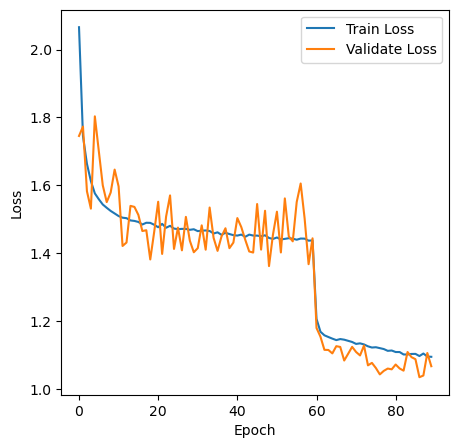

 45%|██████████████████████████████████▏                                         | 90/200 [5:25:59<6:38:56, 217.60s/it]

Epoch:90
Time:5:29:28.746861
Loss:1.0496590177472027
Total:10000  Correct:6227  CleanAccuracy:0.6227


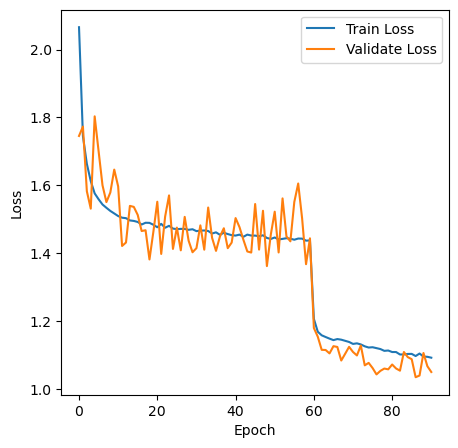

 46%|██████████████████████████████████▌                                         | 91/200 [5:29:36<6:35:08, 217.51s/it]

Epoch:91
Time:5:33:05.896546
Loss:1.062668159556465
Total:10000  Correct:6186  CleanAccuracy:0.6186


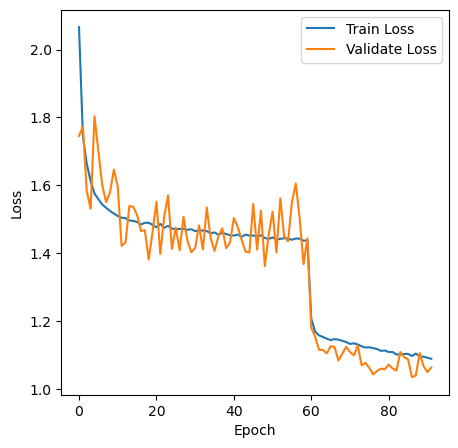

 46%|██████████████████████████████████▉                                         | 92/200 [5:33:13<6:31:20, 217.42s/it]

Epoch:92
Time:5:36:44.259122
Loss:1.0338857301507896
Total:10000  Correct:6258  CleanAccuracy:0.6258


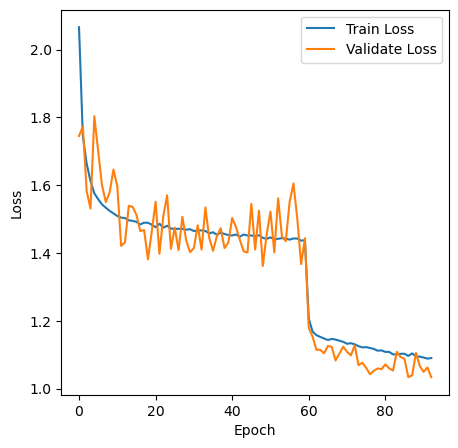

 46%|███████████████████████████████████▎                                        | 93/200 [5:36:51<6:28:05, 217.62s/it]

Epoch:93
Time:5:40:22.519670
Loss:1.042509630465279
Total:10000  Correct:6255  CleanAccuracy:0.6255


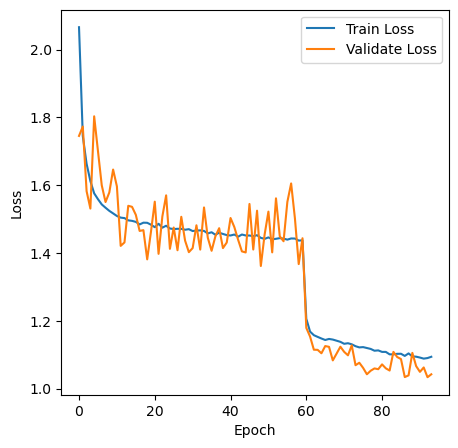

 47%|███████████████████████████████████▋                                        | 94/200 [5:40:29<6:24:38, 217.72s/it]

Epoch:94
Time:5:43:59.426719
Loss:1.0456488213409632
Total:10000  Correct:6303  CleanAccuracy:0.6303


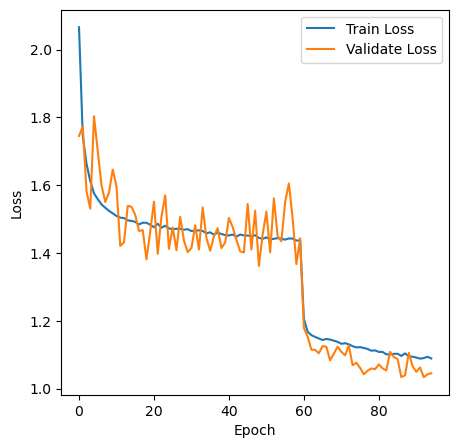

 48%|████████████████████████████████████                                        | 95/200 [5:44:07<6:20:44, 217.57s/it]

Epoch:95
Time:5:47:36.679450
Loss:1.029183184757781
Total:10000  Correct:6302  CleanAccuracy:0.6302


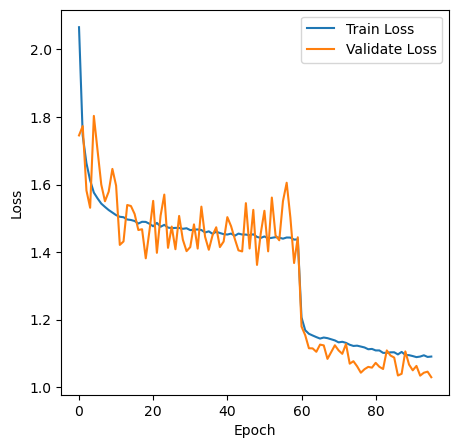

 48%|████████████████████████████████████▍                                       | 96/200 [5:47:44<6:17:06, 217.57s/it]

Epoch:96
Time:5:51:13.134345
Loss:1.0771605183903021
Total:10000  Correct:6156  CleanAccuracy:0.6156


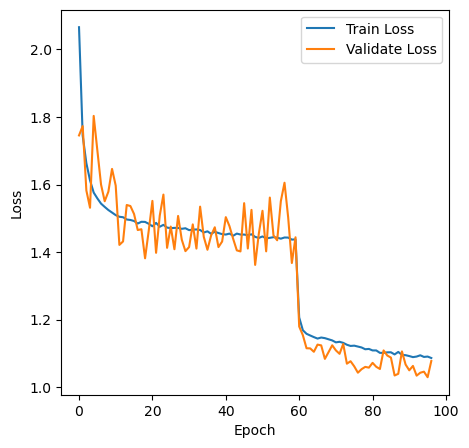

 48%|████████████████████████████████████▊                                       | 97/200 [5:51:20<6:12:52, 217.21s/it]

Epoch:97
Time:5:54:49.807103
Loss:1.0500662077349214
Total:10000  Correct:6177  CleanAccuracy:0.6177


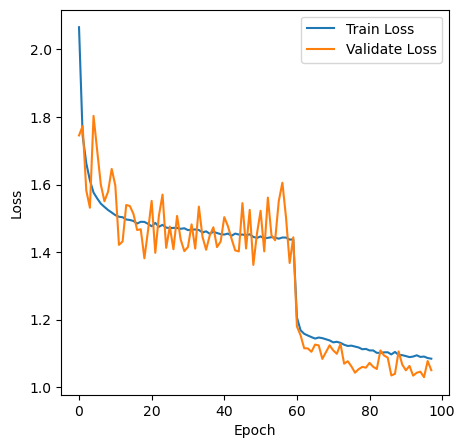

 49%|█████████████████████████████████████▏                                      | 98/200 [5:54:57<6:09:00, 217.06s/it]

Epoch:98
Time:5:58:27.571900
Loss:1.010861281579295
Total:10000  Correct:6373  CleanAccuracy:0.6373


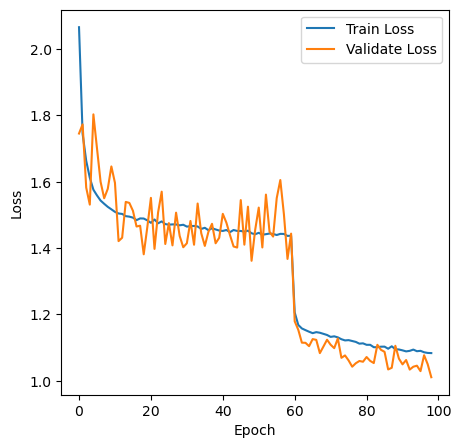

 50%|█████████████████████████████████████▌                                      | 99/200 [5:58:35<6:05:43, 217.26s/it]

Epoch:99
Time:6:02:04.686990
Loss:1.0447745686902787
Total:10000  Correct:6292  CleanAccuracy:0.6292


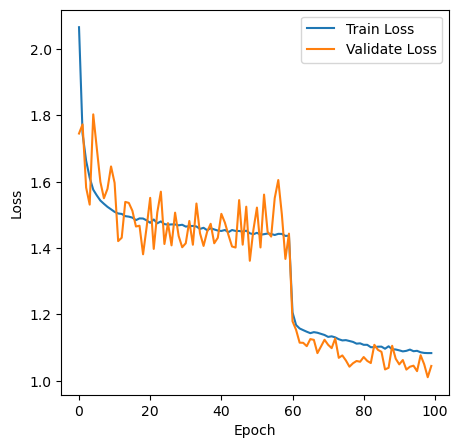

 50%|█████████████████████████████████████▌                                     | 100/200 [6:02:12<6:02:07, 217.27s/it]

Epoch:100
Time:6:05:42.090163
Loss:1.108695752323626
Total:10000  Correct:6027  CleanAccuracy:0.6027


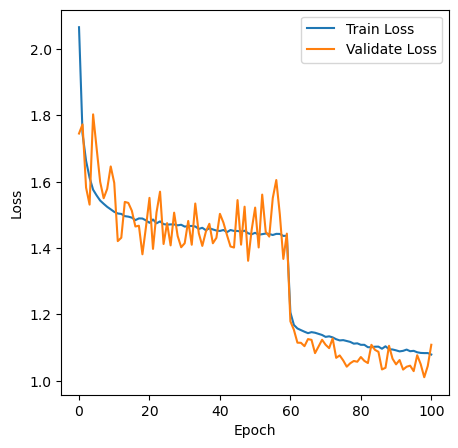

 50%|█████████████████████████████████████▉                                     | 101/200 [6:05:50<5:58:34, 217.31s/it]

Epoch:101
Time:6:09:19.788095
Loss:0.9961599174398965
Total:10000  Correct:6458  CleanAccuracy:0.6458


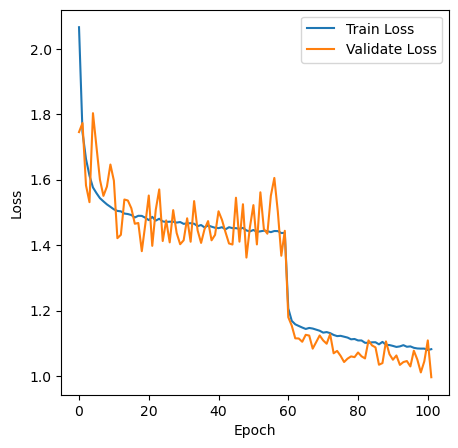

 51%|██████████████████████████████████████▎                                    | 102/200 [6:09:27<5:55:09, 217.45s/it]

Epoch:102
Time:6:12:57.439521
Loss:1.1055816596689316
Total:10000  Correct:6014  CleanAccuracy:0.6014


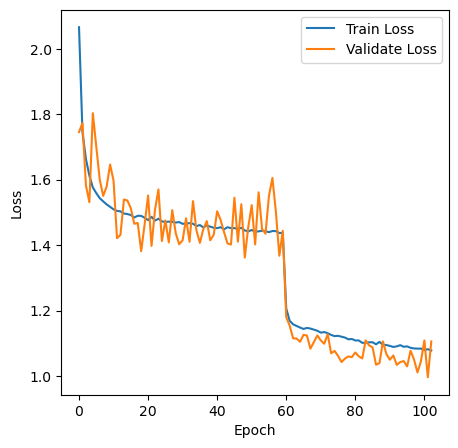

 52%|██████████████████████████████████████▋                                    | 103/200 [6:13:05<5:51:35, 217.48s/it]

Epoch:103
Time:6:16:35.188843
Loss:1.0587896984606124
Total:10000  Correct:6217  CleanAccuracy:0.6217


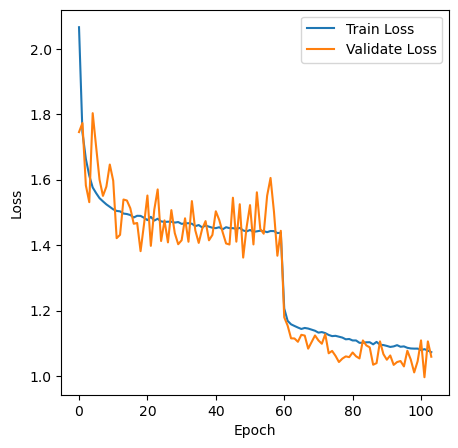

 52%|███████████████████████████████████████                                    | 104/200 [6:16:43<5:48:07, 217.58s/it]

Epoch:104
Time:6:20:12.451470
Loss:0.9901370013864658
Total:10000  Correct:6439  CleanAccuracy:0.6439


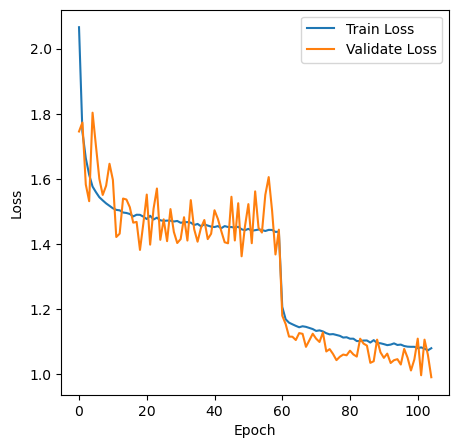

 52%|███████████████████████████████████████▍                                   | 105/200 [6:20:20<5:44:15, 217.42s/it]

Epoch:105
Time:6:23:49.757411
Loss:1.0101405755399515
Total:10000  Correct:6418  CleanAccuracy:0.6418


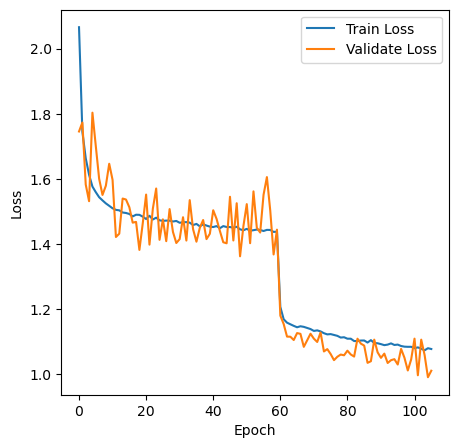

 53%|███████████████████████████████████████▊                                   | 106/200 [6:23:57<5:40:26, 217.31s/it]

Epoch:106
Time:6:27:27.576184
Loss:1.026897764624879
Total:10000  Correct:6333  CleanAccuracy:0.6333


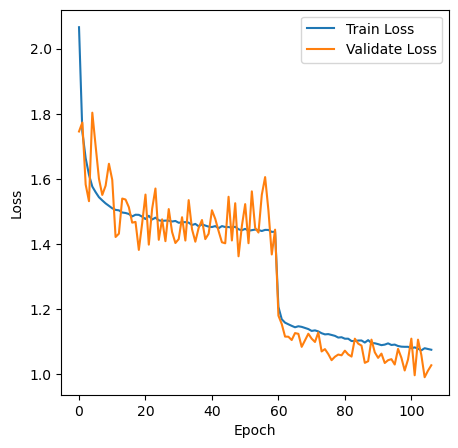

 54%|████████████████████████████████████████▏                                  | 107/200 [6:27:34<5:36:56, 217.38s/it]

Epoch:107
Time:6:31:03.382210
Loss:1.0155107757915705
Total:10000  Correct:6343  CleanAccuracy:0.6343


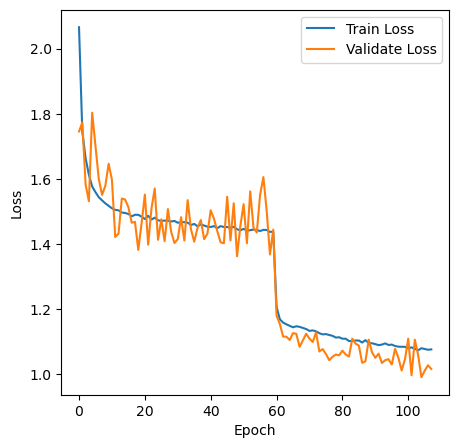

 54%|████████████████████████████████████████▌                                  | 108/200 [6:31:11<5:32:54, 217.12s/it]

Epoch:108
Time:6:34:40.328472
Loss:1.0267147117148574
Total:10000  Correct:6319  CleanAccuracy:0.6319


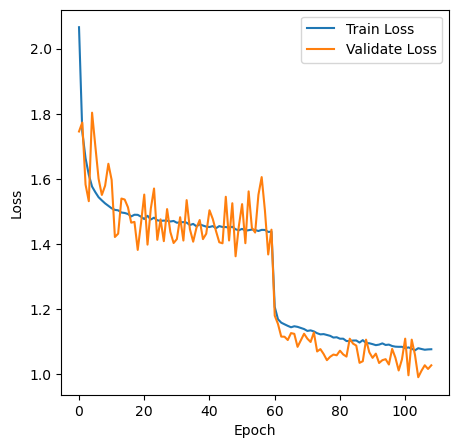

 55%|████████████████████████████████████████▉                                  | 109/200 [6:34:48<5:29:13, 217.07s/it]

Epoch:109
Time:6:38:17.707109
Loss:1.0262645132625445
Total:10000  Correct:6325  CleanAccuracy:0.6325


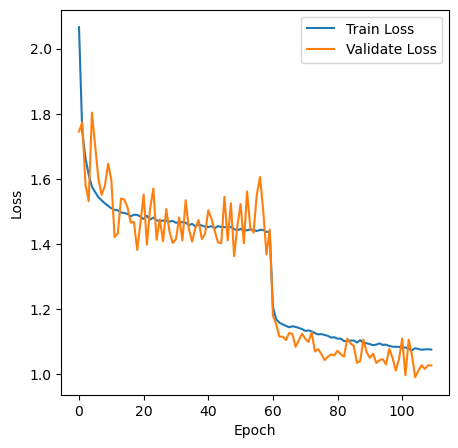

 55%|█████████████████████████████████████████▎                                 | 110/200 [6:38:25<5:25:36, 217.07s/it]

Epoch:110
Time:6:41:55.055454
Loss:1.038960609573145
Total:10000  Correct:6352  CleanAccuracy:0.6352


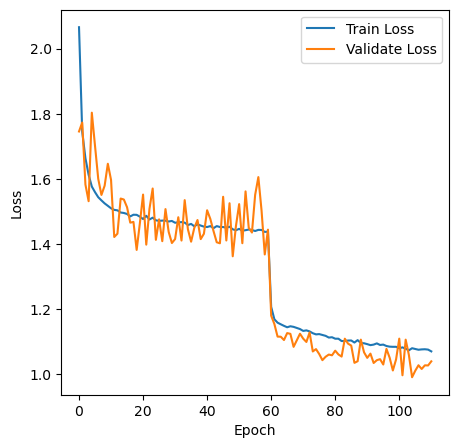

 56%|█████████████████████████████████████████▋                                 | 111/200 [6:42:02<5:22:11, 217.21s/it]

Epoch:111
Time:6:45:32.604705
Loss:1.0027308161266315
Total:10000  Correct:6412  CleanAccuracy:0.6412


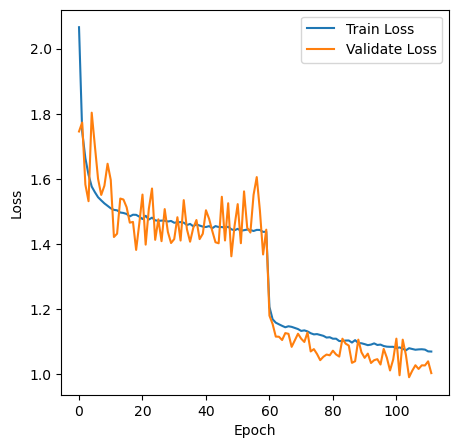

 56%|██████████████████████████████████████████                                 | 112/200 [6:45:40<5:18:41, 217.29s/it]

Epoch:112
Time:6:49:10.358856
Loss:1.003653392052879
Total:10000  Correct:6353  CleanAccuracy:0.6353


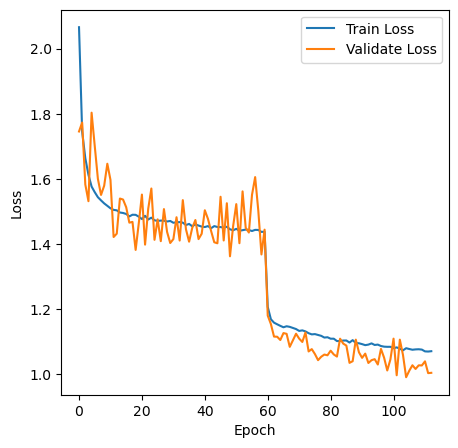

 56%|██████████████████████████████████████████▎                                | 113/200 [6:49:18<5:15:19, 217.46s/it]

Epoch:113
Time:6:52:47.777656
Loss:1.0763466857111872
Total:10000  Correct:6124  CleanAccuracy:0.6124


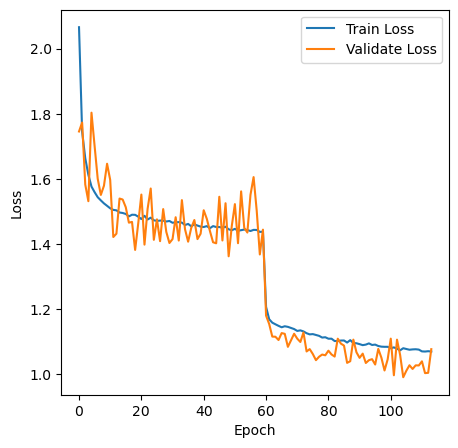

 57%|██████████████████████████████████████████▋                                | 114/200 [6:52:55<5:11:33, 217.36s/it]

Epoch:114
Time:6:56:24.642400
Loss:1.0251445629345342
Total:10000  Correct:6352  CleanAccuracy:0.6352


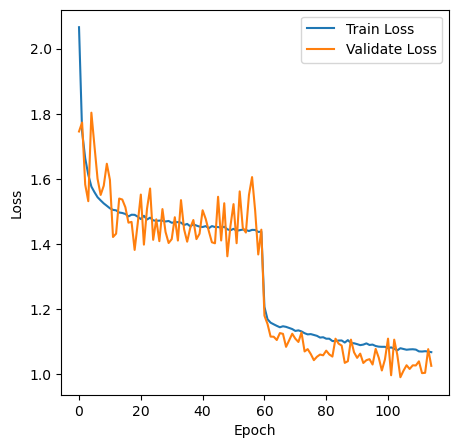

 57%|███████████████████████████████████████████▏                               | 115/200 [6:56:32<5:07:51, 217.31s/it]

Epoch:115
Time:7:00:03.180593
Loss:1.0179892481325534
Total:10000  Correct:6364  CleanAccuracy:0.6364


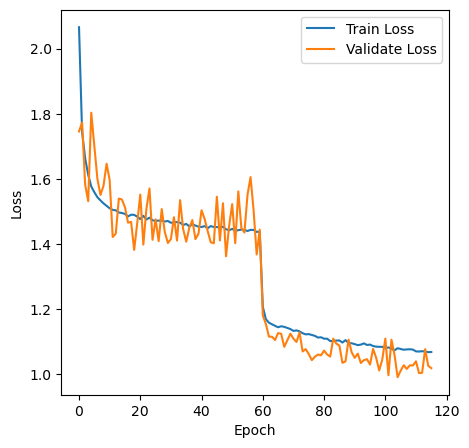

 58%|███████████████████████████████████████████▌                               | 116/200 [7:00:11<5:04:46, 217.69s/it]

Epoch:116
Time:7:03:40.418269
Loss:1.0158920400439742
Total:10000  Correct:6369  CleanAccuracy:0.6369


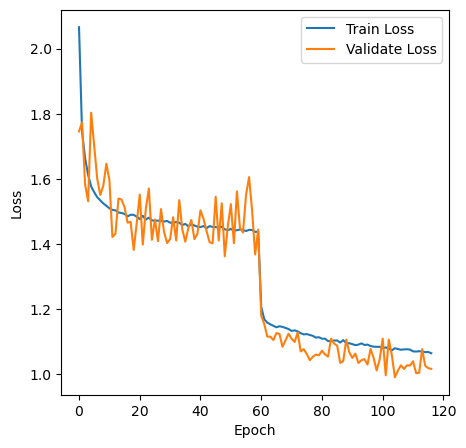

 58%|███████████████████████████████████████████▉                               | 117/200 [7:03:48<5:00:59, 217.58s/it]

Epoch:117
Time:7:07:18.724130
Loss:1.0389229407706582
Total:10000  Correct:6234  CleanAccuracy:0.6234


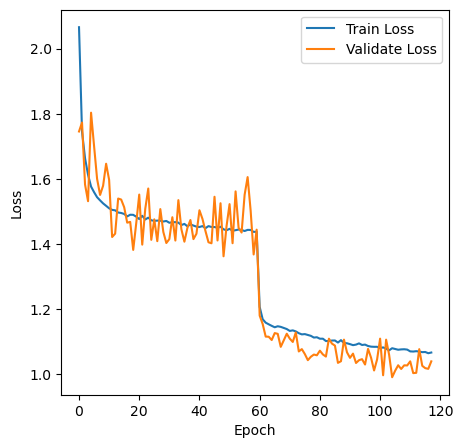

 59%|████████████████████████████████████████████▎                              | 118/200 [7:07:25<4:57:07, 217.41s/it]

Epoch:118
Time:7:10:56.566082
Loss:1.0214051208176171
Total:10000  Correct:6317  CleanAccuracy:0.6317


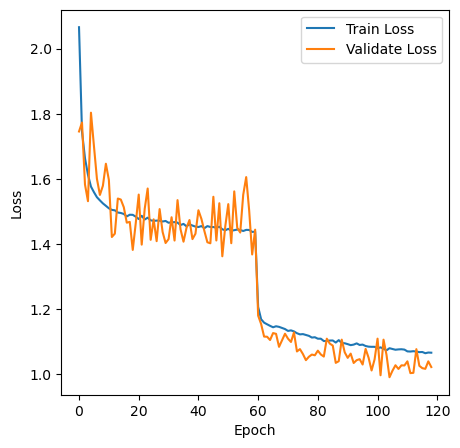

 60%|████████████████████████████████████████████▋                              | 119/200 [7:11:04<4:54:02, 217.81s/it]

Epoch:119
Time:7:14:34.872935
Loss:1.0147720066884074
Total:10000  Correct:6354  CleanAccuracy:0.6354


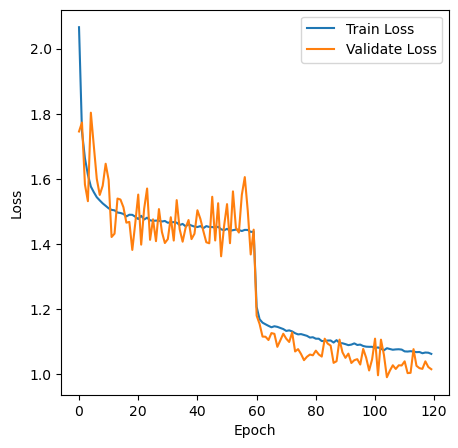

 60%|█████████████████████████████████████████████                              | 120/200 [7:14:42<4:50:41, 218.01s/it]

Epoch:120
Time:7:18:13.855945
Loss:0.9299745710132221
Total:10000  Correct:6655  CleanAccuracy:0.6655


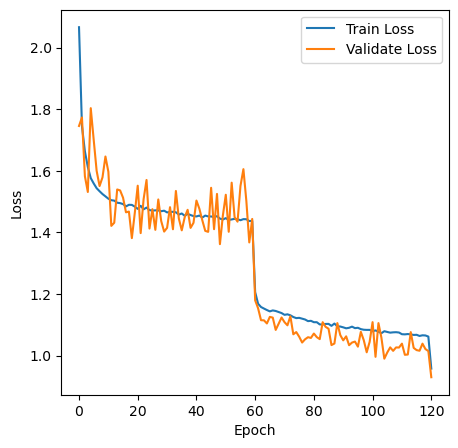

 60%|█████████████████████████████████████████████▍                             | 121/200 [7:18:21<4:47:27, 218.32s/it]

Epoch:121
Time:7:21:51.967037
Loss:0.9016737606578742
Total:10000  Correct:6736  CleanAccuracy:0.6736


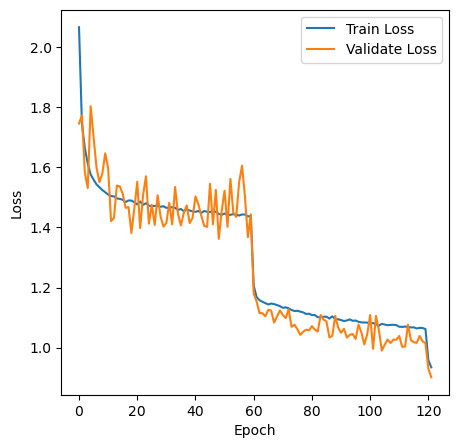

 61%|█████████████████████████████████████████████▊                             | 122/200 [7:21:59<4:43:43, 218.25s/it]

Epoch:122
Time:7:25:29.467118
Loss:0.8847973773273797
Total:10000  Correct:6846  CleanAccuracy:0.6846


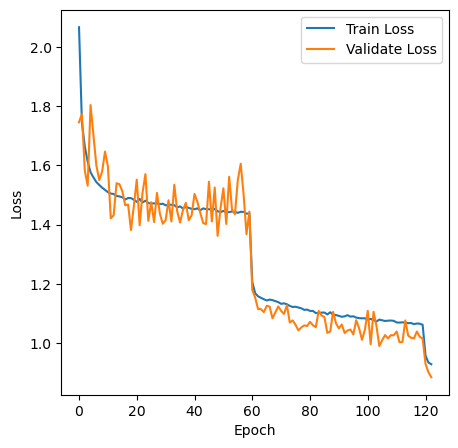

 62%|██████████████████████████████████████████████▏                            | 123/200 [7:25:37<4:39:50, 218.06s/it]

Epoch:123
Time:7:29:06.976866
Loss:0.9063778323487351
Total:10000  Correct:6739  CleanAccuracy:0.6739


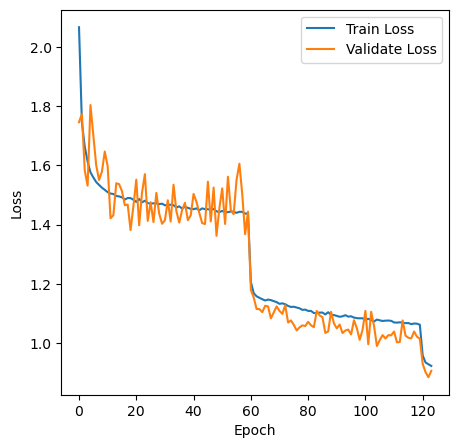

 62%|██████████████████████████████████████████████▌                            | 124/200 [7:29:14<4:35:55, 217.84s/it]

Epoch:124
Time:7:32:43.217253
Loss:0.8933046408735525
Total:10000  Correct:6797  CleanAccuracy:0.6797


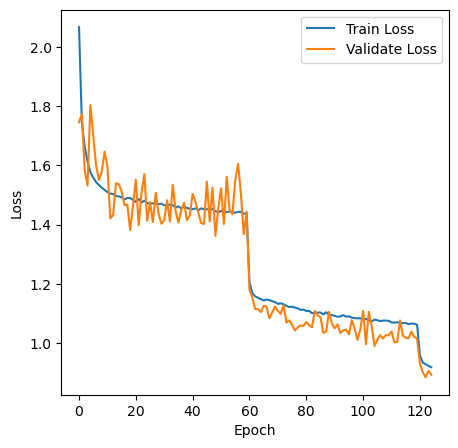

 62%|██████████████████████████████████████████████▉                            | 125/200 [7:32:51<4:31:44, 217.39s/it]

Epoch:125
Time:7:36:20.549232
Loss:0.8724698525267287
Total:10000  Correct:6861  CleanAccuracy:0.6861


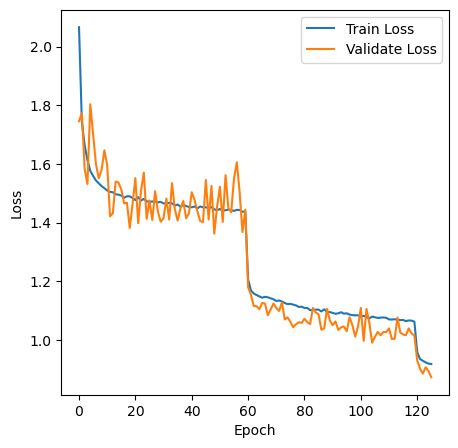

 63%|███████████████████████████████████████████████▎                           | 126/200 [7:36:28<4:28:04, 217.36s/it]

Epoch:126
Time:7:39:57.687820
Loss:0.8792727687678779
Total:10000  Correct:6860  CleanAccuracy:0.6860


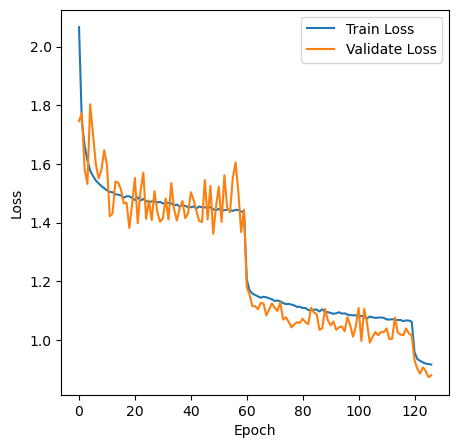

 64%|███████████████████████████████████████████████▋                           | 127/200 [7:40:05<4:24:17, 217.23s/it]

Epoch:127
Time:7:43:34.912060
Loss:0.8799714118527909
Total:10000  Correct:6847  CleanAccuracy:0.6847


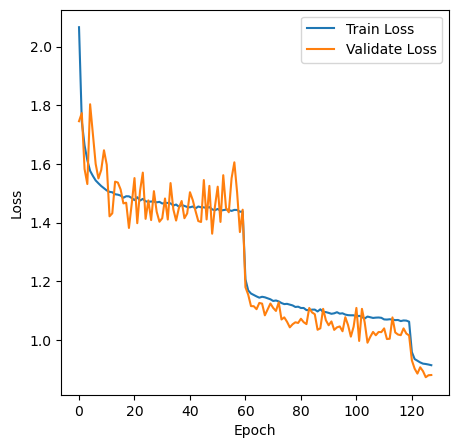

 64%|████████████████████████████████████████████████                           | 128/200 [7:43:42<4:20:43, 217.28s/it]

Epoch:128
Time:7:47:13.217535
Loss:0.8887321130155375
Total:10000  Correct:6774  CleanAccuracy:0.6774


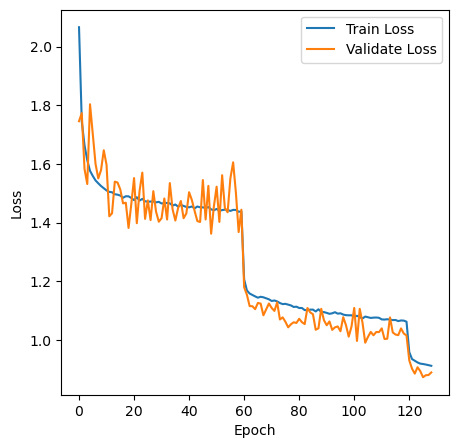

 64%|████████████████████████████████████████████████▍                          | 129/200 [7:47:21<4:17:29, 217.60s/it]

Epoch:129
Time:7:50:51.256600
Loss:0.8772987814757008
Total:10000  Correct:6878  CleanAccuracy:0.6878


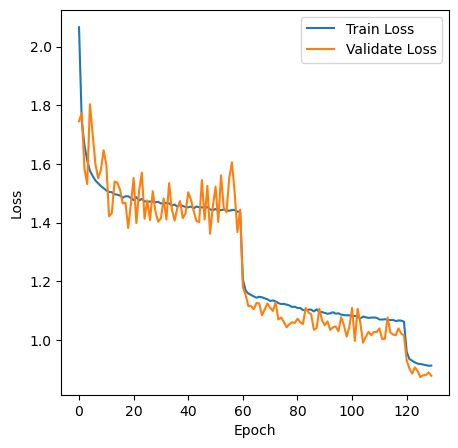

 65%|████████████████████████████████████████████████▊                          | 130/200 [7:50:58<4:13:50, 217.57s/it]

Epoch:130
Time:7:54:27.794065
Loss:0.872589815348482
Total:10000  Correct:6890  CleanAccuracy:0.6890


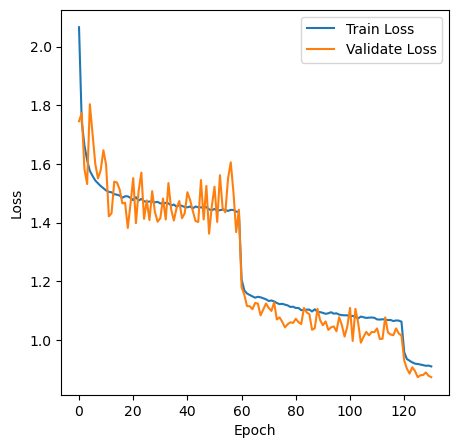

 66%|█████████████████████████████████████████████████▏                         | 131/200 [7:54:35<4:10:02, 217.43s/it]

Epoch:131
Time:7:58:06.314030
Loss:0.8931464913744516
Total:10000  Correct:6818  CleanAccuracy:0.6818


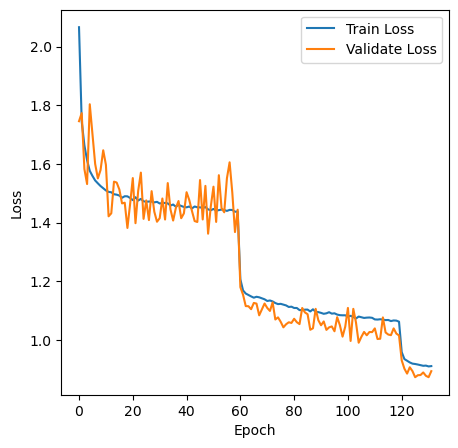

 66%|█████████████████████████████████████████████████▌                         | 132/200 [7:58:14<4:06:48, 217.78s/it]

Epoch:132
Time:8:01:44.463845
Loss:0.8974746692294892
Total:10000  Correct:6869  CleanAccuracy:0.6869


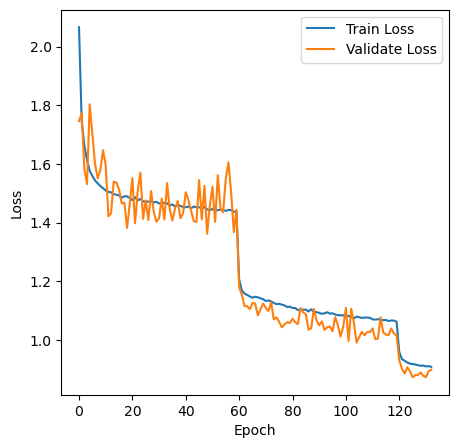

 66%|█████████████████████████████████████████████████▉                         | 133/200 [8:01:52<4:03:14, 217.83s/it]

Epoch:133
Time:8:05:21.534109
Loss:0.8717536296897803
Total:10000  Correct:6891  CleanAccuracy:0.6891


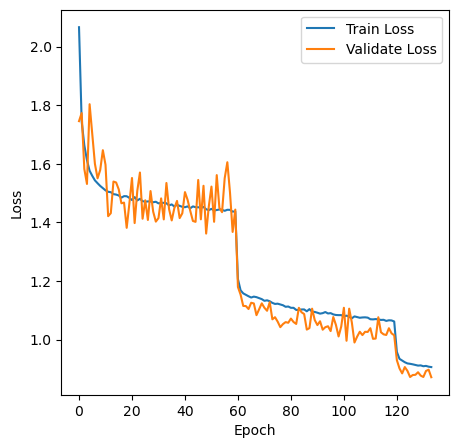

 67%|██████████████████████████████████████████████████▎                        | 134/200 [8:05:29<3:59:24, 217.65s/it]

Epoch:134
Time:8:08:58.605536
Loss:0.8782687634705736
Total:10000  Correct:6859  CleanAccuracy:0.6859


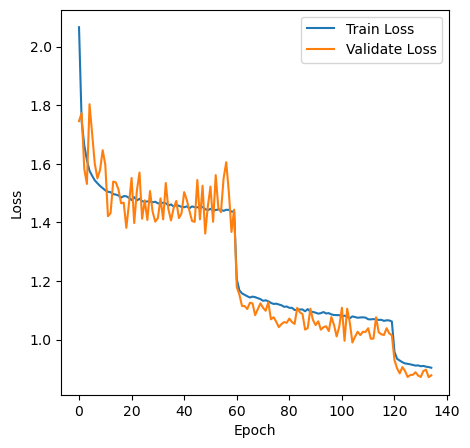

 68%|██████████████████████████████████████████████████▋                        | 135/200 [8:09:06<3:55:35, 217.47s/it]

Epoch:135
Time:8:12:35.982626
Loss:0.8855640761578045
Total:10000  Correct:6829  CleanAccuracy:0.6829


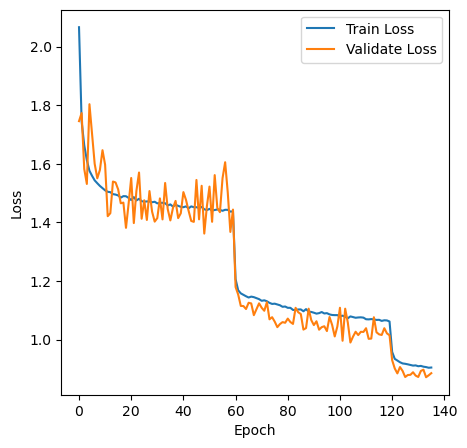

 68%|███████████████████████████████████████████████████                        | 136/200 [8:12:44<3:51:57, 217.46s/it]

Epoch:136
Time:8:16:14.243645
Loss:0.8926980503070088
Total:10000  Correct:6798  CleanAccuracy:0.6798


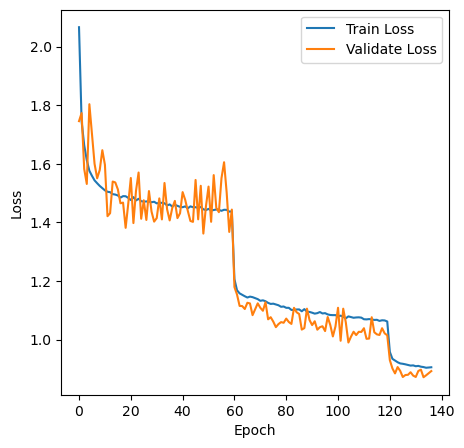

 68%|███████████████████████████████████████████████████▍                       | 137/200 [8:16:22<3:48:33, 217.67s/it]

Epoch:137
Time:8:19:52.644934
Loss:0.9016201069560675
Total:10000  Correct:6803  CleanAccuracy:0.6803


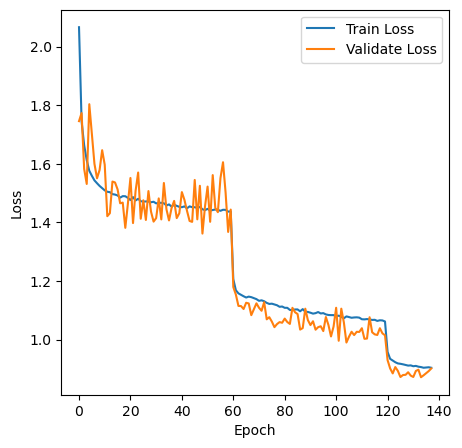

 69%|███████████████████████████████████████████████████▋                       | 138/200 [8:20:00<3:45:08, 217.88s/it]

Epoch:138
Time:8:23:30.130885
Loss:0.8759267926216125
Total:10000  Correct:6899  CleanAccuracy:0.6899


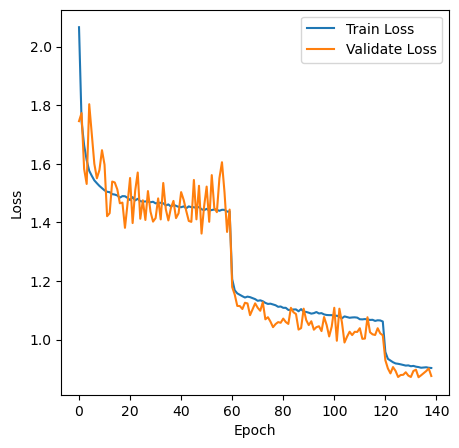

 70%|████████████████████████████████████████████████████                       | 139/200 [8:23:38<3:41:25, 217.79s/it]

Epoch:139
Time:8:27:07.200688
Loss:0.8729169603925162
Total:10000  Correct:6923  CleanAccuracy:0.6923


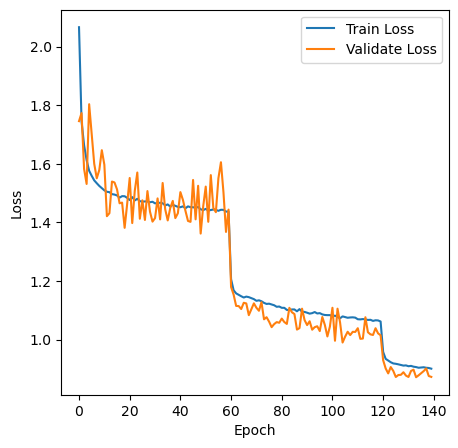

 70%|████████████████████████████████████████████████████▌                      | 140/200 [8:27:15<3:37:35, 217.59s/it]

Epoch:140
Time:8:30:44.419670
Loss:0.8710474156723997
Total:10000  Correct:6882  CleanAccuracy:0.6882


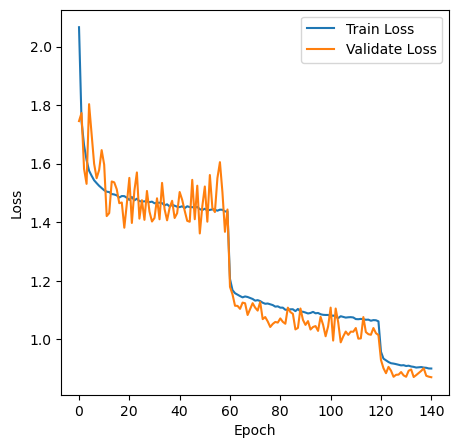

 70%|████████████████████████████████████████████████████▉                      | 141/200 [8:30:52<3:33:52, 217.50s/it]

Epoch:141
Time:8:34:22.003700
Loss:0.8690306454801712
Total:10000  Correct:6884  CleanAccuracy:0.6884


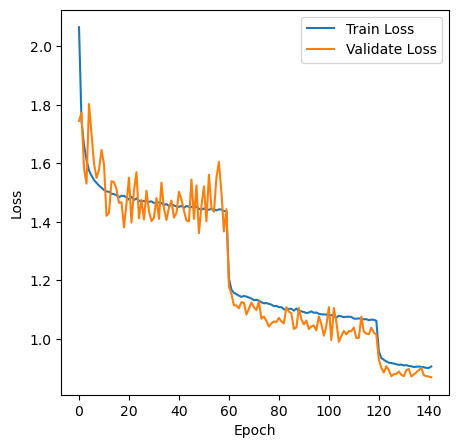

 71%|█████████████████████████████████████████████████████▎                     | 142/200 [8:34:29<3:30:09, 217.41s/it]

Epoch:142
Time:8:38:00.145003
Loss:0.8755458076350605
Total:10000  Correct:6832  CleanAccuracy:0.6832


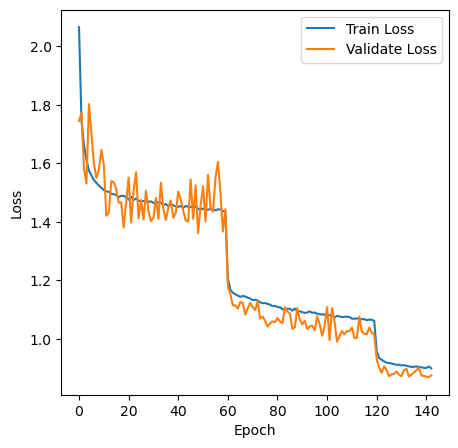

 72%|█████████████████████████████████████████████████████▋                     | 143/200 [8:38:07<3:26:36, 217.48s/it]

Epoch:143
Time:8:41:37.519715
Loss:0.8798450212509107
Total:10000  Correct:6880  CleanAccuracy:0.6880


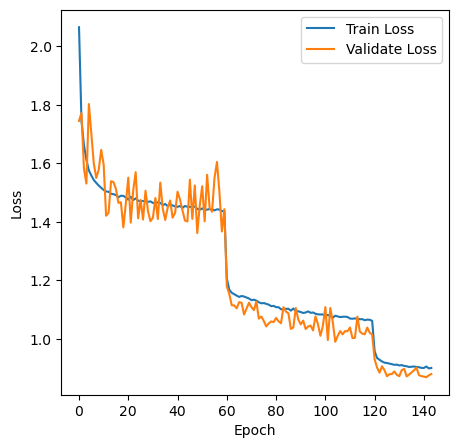

 72%|██████████████████████████████████████████████████████                     | 144/200 [8:41:44<3:23:00, 217.50s/it]

Epoch:144
Time:8:45:14.672498
Loss:0.885416998173863
Total:10000  Correct:6861  CleanAccuracy:0.6861


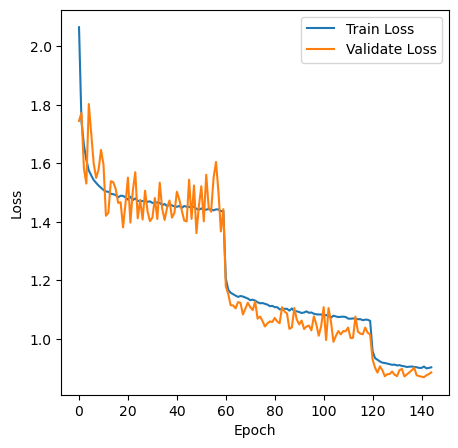

 72%|██████████████████████████████████████████████████████▍                    | 145/200 [8:45:22<3:19:25, 217.56s/it]

Epoch:145
Time:8:48:52.090949
Loss:0.874231763350697
Total:10000  Correct:6878  CleanAccuracy:0.6878


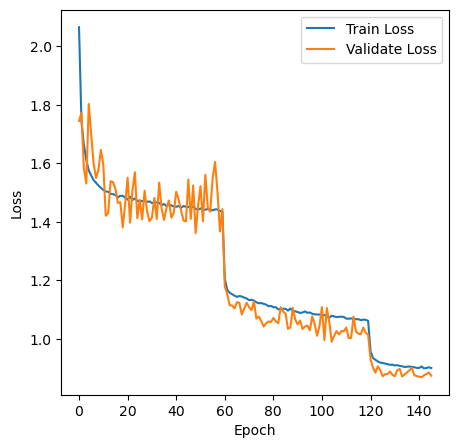

 73%|██████████████████████████████████████████████████████▊                    | 146/200 [8:48:59<3:15:41, 217.43s/it]

Epoch:146
Time:8:52:30.374188
Loss:0.8889328202310081
Total:10000  Correct:6824  CleanAccuracy:0.6824


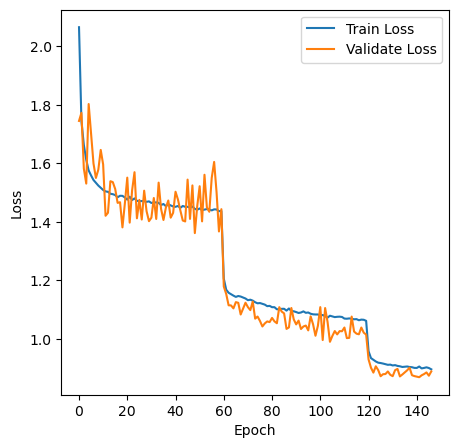

 74%|███████████████████████████████████████████████████████▏                   | 147/200 [8:52:38<3:12:21, 217.76s/it]

Epoch:147
Time:8:56:07.340363
Loss:0.8588709242808552
Total:10000  Correct:6904  CleanAccuracy:0.6904


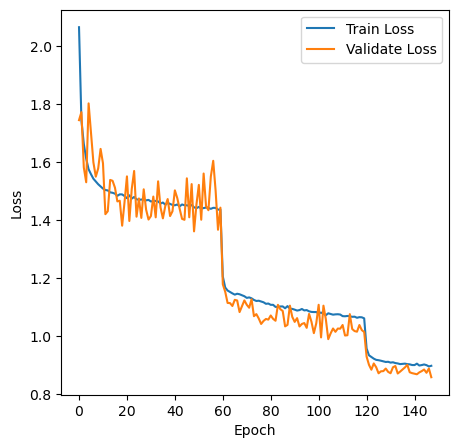

 74%|███████████████████████████████████████████████████████▌                   | 148/200 [8:56:15<3:08:30, 217.52s/it]

Epoch:148
Time:8:59:44.170971
Loss:0.8777859382355175
Total:10000  Correct:6883  CleanAccuracy:0.6883


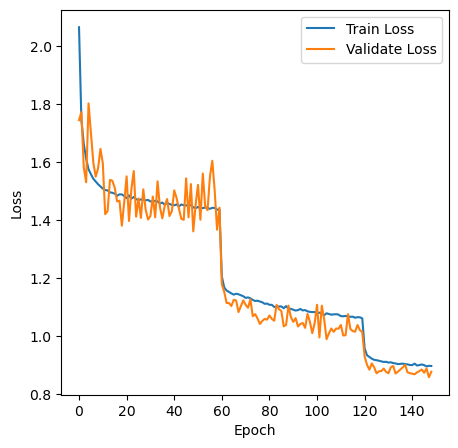

 74%|███████████████████████████████████████████████████████▉                   | 149/200 [8:59:52<3:04:44, 217.35s/it]

Epoch:149
Time:9:03:21.532967
Loss:0.8733224745946951
Total:10000  Correct:6890  CleanAccuracy:0.6890


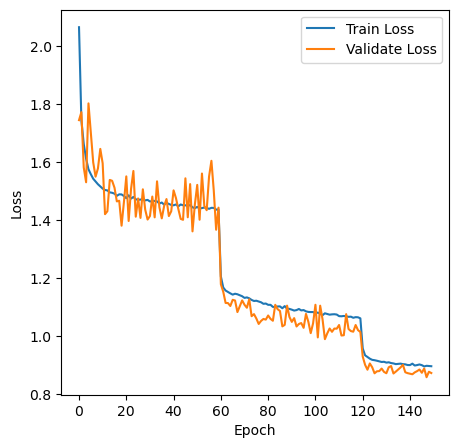

 75%|████████████████████████████████████████████████████████▎                  | 150/200 [9:03:29<3:01:09, 217.38s/it]

Epoch:150
Time:9:06:59.918147
Loss:0.8712388627445355
Total:10000  Correct:6879  CleanAccuracy:0.6879


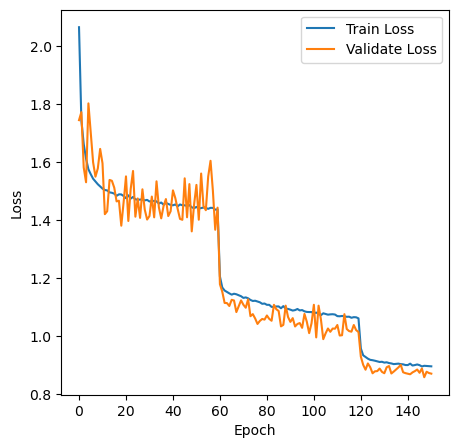

 76%|████████████████████████████████████████████████████████▋                  | 151/200 [9:07:07<2:57:44, 217.65s/it]

Epoch:151
Time:9:10:37.774545
Loss:0.8881300534493626
Total:10000  Correct:6833  CleanAccuracy:0.6833


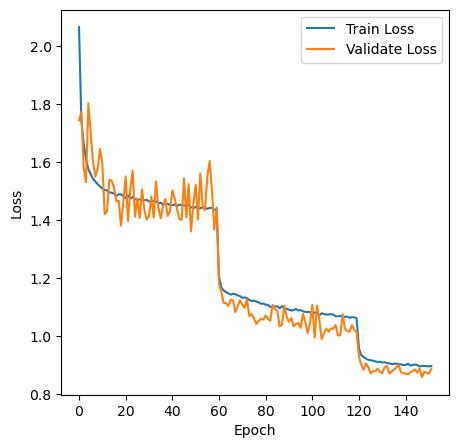

 76%|█████████████████████████████████████████████████████████                  | 152/200 [9:10:45<2:54:11, 217.75s/it]

Epoch:152
Time:9:14:15.343034
Loss:0.8662695233433392
Total:10000  Correct:6933  CleanAccuracy:0.6933


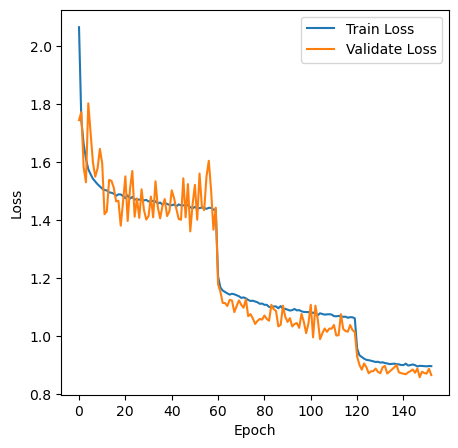

 76%|█████████████████████████████████████████████████████████▍                 | 153/200 [9:14:23<2:50:29, 217.64s/it]

Epoch:153
Time:9:17:53.120313
Loss:0.8779104975656199
Total:10000  Correct:6889  CleanAccuracy:0.6889


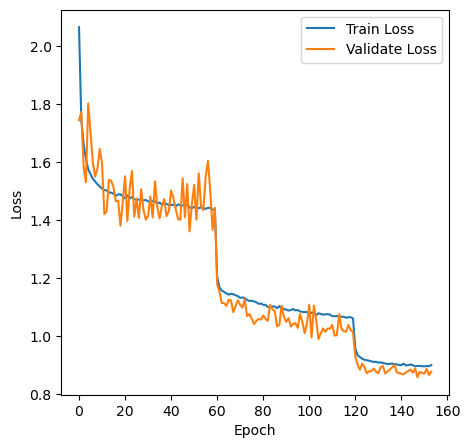

 77%|█████████████████████████████████████████████████████████▊                 | 154/200 [9:18:01<2:46:52, 217.66s/it]

Epoch:154
Time:9:21:30.931768
Loss:0.8532681891712518
Total:10000  Correct:6956  CleanAccuracy:0.6956


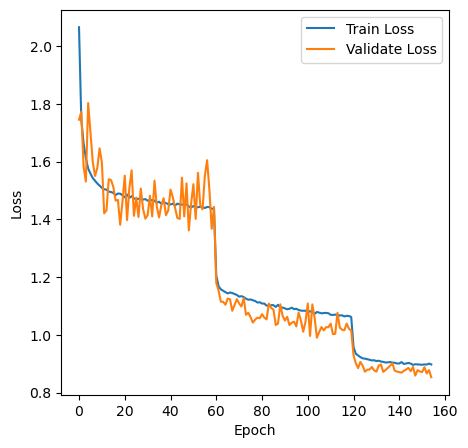

 78%|██████████████████████████████████████████████████████████▏                | 155/200 [9:21:38<2:43:18, 217.75s/it]

Epoch:155
Time:9:25:09.397231
Loss:0.883783594487955
Total:10000  Correct:6849  CleanAccuracy:0.6849


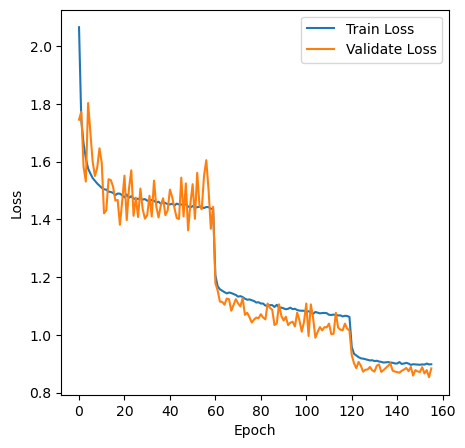

 78%|██████████████████████████████████████████████████████████▌                | 156/200 [9:25:16<2:39:38, 217.69s/it]

Epoch:156
Time:9:28:46.636841
Loss:0.8520977400933591
Total:10000  Correct:6951  CleanAccuracy:0.6951


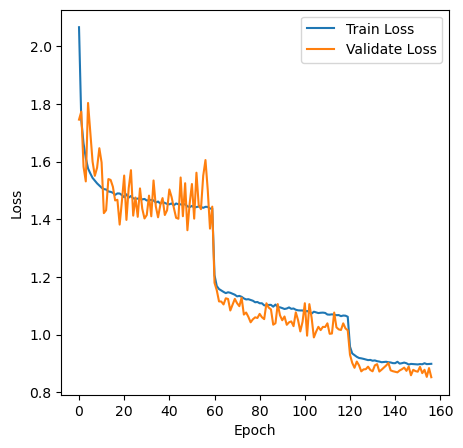

 78%|██████████████████████████████████████████████████████████▉                | 157/200 [9:28:54<2:36:05, 217.80s/it]

Epoch:157
Time:9:32:23.613116
Loss:0.8569909945463601
Total:10000  Correct:6959  CleanAccuracy:0.6959


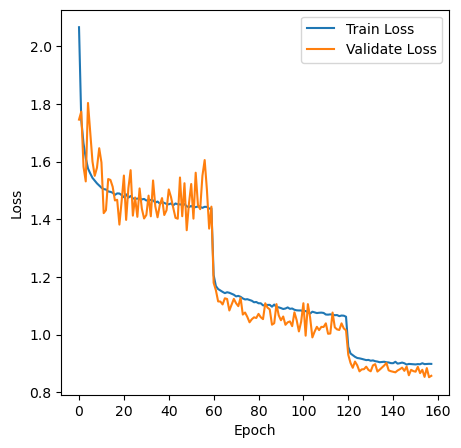

 79%|███████████████████████████████████████████████████████████▎               | 158/200 [9:32:31<2:32:18, 217.59s/it]

Epoch:158
Time:9:36:02.188380
Loss:0.8826158319037563
Total:10000  Correct:6893  CleanAccuracy:0.6893


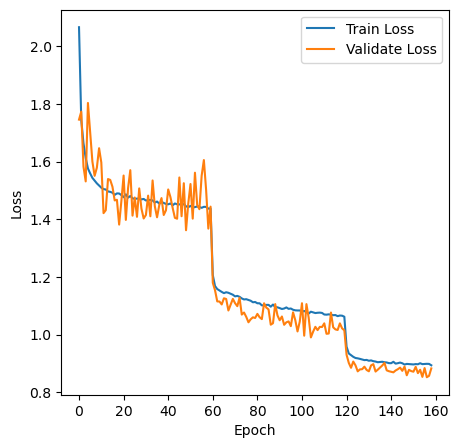

 80%|███████████████████████████████████████████████████████████▋               | 159/200 [9:36:10<2:28:53, 217.89s/it]

Epoch:159
Time:9:39:40.395728
Loss:0.8630187129631591
Total:10000  Correct:6919  CleanAccuracy:0.6919


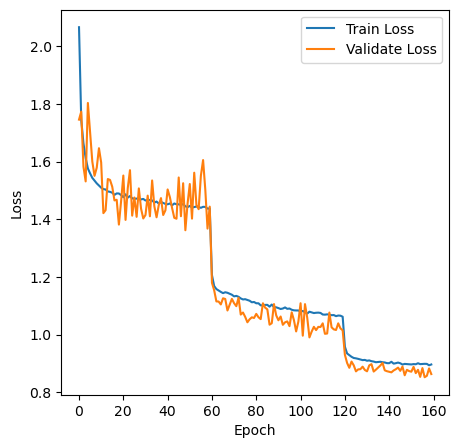

 80%|████████████████████████████████████████████████████████████               | 160/200 [9:39:48<2:25:20, 218.00s/it]

Epoch:160
Time:9:43:17.939737
Loss:0.8607417375515825
Total:10000  Correct:6899  CleanAccuracy:0.6899


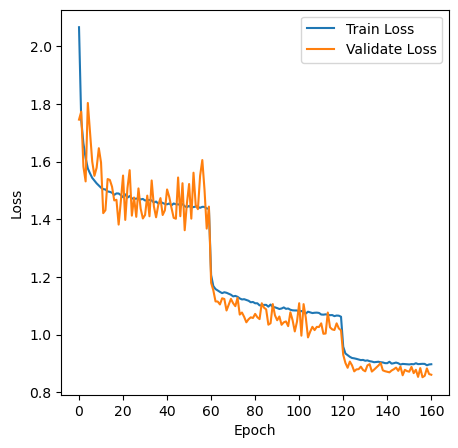

 80%|████████████████████████████████████████████████████████████▍              | 161/200 [9:43:25<2:21:34, 217.80s/it]

Epoch:161
Time:9:46:54.901110
Loss:0.9029202243200125
Total:10000  Correct:6849  CleanAccuracy:0.6849


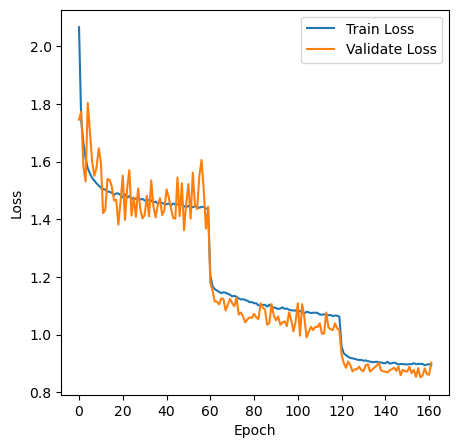

 81%|████████████████████████████████████████████████████████████▊              | 162/200 [9:47:02<2:17:46, 217.54s/it]

Epoch:162
Time:9:50:32.502810
Loss:0.8634048406118021
Total:10000  Correct:6981  CleanAccuracy:0.6981


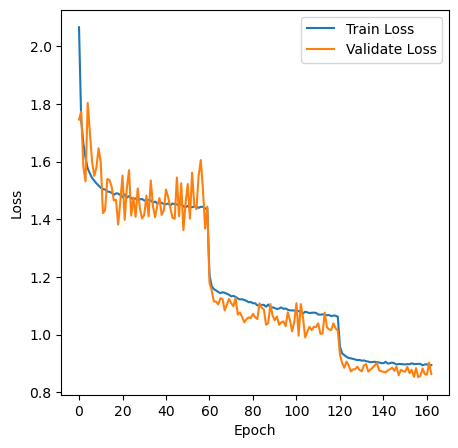

 82%|█████████████████████████████████████████████████████████████              | 163/200 [9:50:40<2:14:10, 217.59s/it]

Epoch:163
Time:9:54:09.657340
Loss:0.8734273489671774
Total:10000  Correct:6857  CleanAccuracy:0.6857


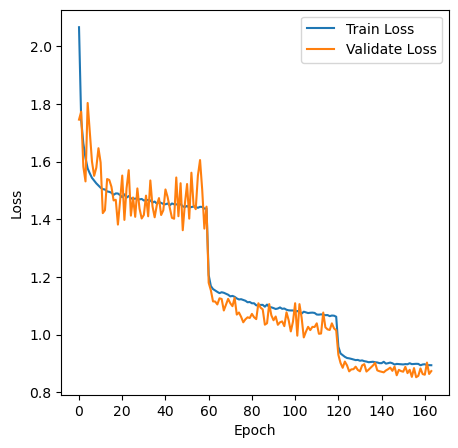

 82%|█████████████████████████████████████████████████████████████▍             | 164/200 [9:54:17<2:10:29, 217.48s/it]

Epoch:164
Time:9:57:47.694736
Loss:0.8650711519649615
Total:10000  Correct:6947  CleanAccuracy:0.6947


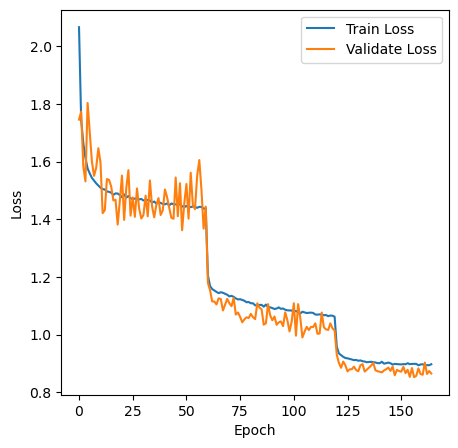

 82%|█████████████████████████████████████████████████████████████▉             | 165/200 [9:57:55<2:06:55, 217.59s/it]

Epoch:165
Time:10:01:25.039690
Loss:0.8941749095345457
Total:10000  Correct:6838  CleanAccuracy:0.6838


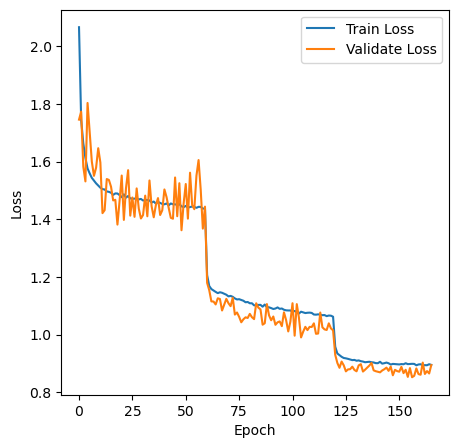

 83%|█████████████████████████████████████████████████████████████▍            | 166/200 [10:01:32<2:03:16, 217.53s/it]

Epoch:166
Time:10:05:02.454124
Loss:0.8716592211692858
Total:10000  Correct:6892  CleanAccuracy:0.6892


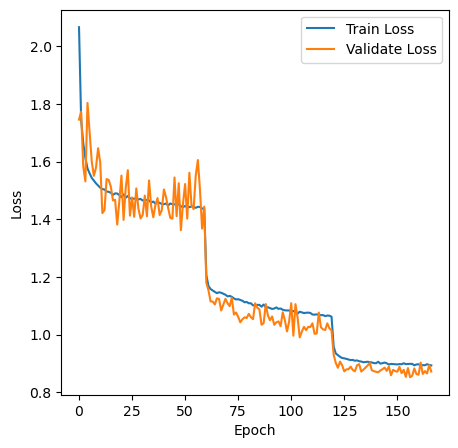

 84%|█████████████████████████████████████████████████████████████▊            | 167/200 [10:05:10<1:59:38, 217.52s/it]

Epoch:167
Time:10:08:39.695197
Loss:0.8981203508262817
Total:10000  Correct:6830  CleanAccuracy:0.6830


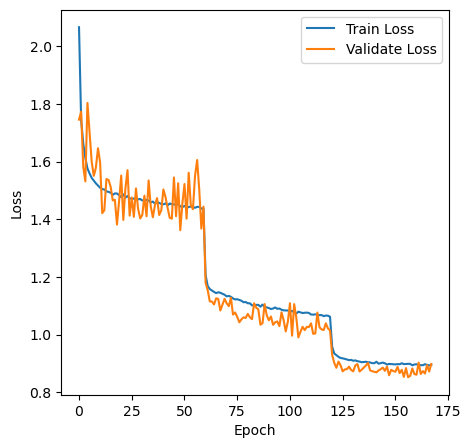

 84%|██████████████████████████████████████████████████████████████▏           | 168/200 [10:08:46<1:55:46, 217.09s/it]

Epoch:168
Time:10:12:16.537724
Loss:0.8823008690588772
Total:10000  Correct:6865  CleanAccuracy:0.6865


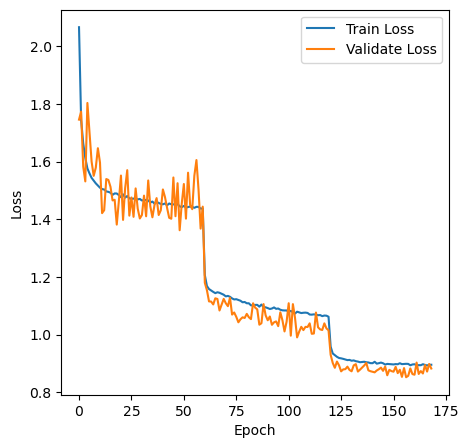

 84%|██████████████████████████████████████████████████████████████▌           | 169/200 [10:12:23<1:52:11, 217.16s/it]

Epoch:169
Time:10:15:51.507003
Loss:0.8619917068428125
Total:10000  Correct:6917  CleanAccuracy:0.6917


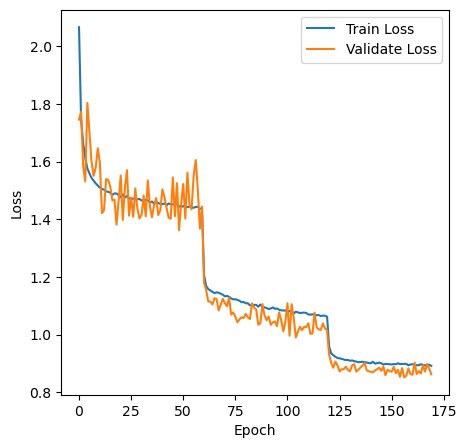

 85%|██████████████████████████████████████████████████████████████▉           | 170/200 [10:15:59<1:48:21, 216.71s/it]

Epoch:170
Time:10:19:27.506272
Loss:0.8566416181124057
Total:10000  Correct:6966  CleanAccuracy:0.6966


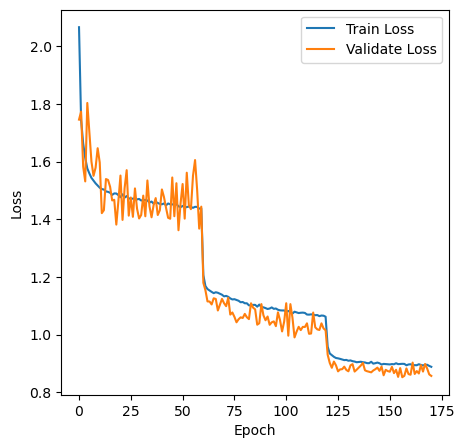

 86%|███████████████████████████████████████████████████████████████▎          | 171/200 [10:19:35<1:44:37, 216.46s/it]

Epoch:171
Time:10:23:03.909481
Loss:0.8651511708197122
Total:10000  Correct:6918  CleanAccuracy:0.6918


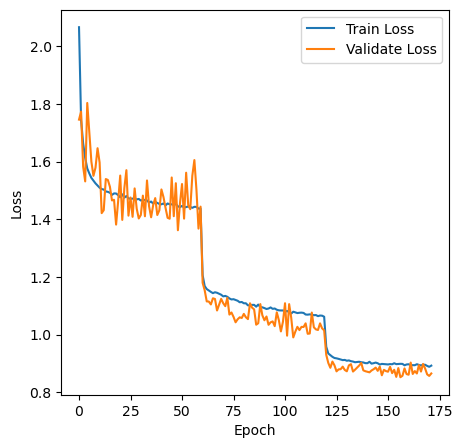

 86%|███████████████████████████████████████████████████████████████▋          | 172/200 [10:23:11<1:41:00, 216.44s/it]

Epoch:172
Time:10:26:40.278343
Loss:0.8462010786746638
Total:10000  Correct:7010  CleanAccuracy:0.7010


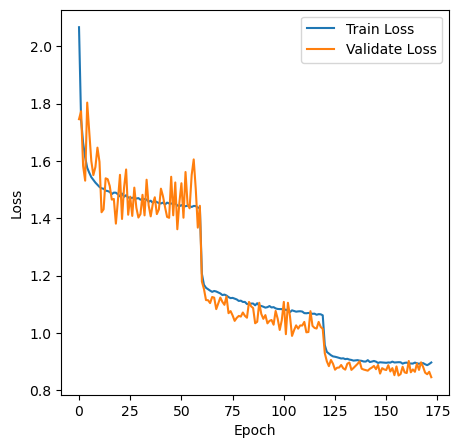

 86%|████████████████████████████████████████████████████████████████          | 173/200 [10:26:48<1:37:24, 216.46s/it]

Epoch:173
Time:10:30:16.864731
Loss:0.8771266013669511
Total:10000  Correct:6886  CleanAccuracy:0.6886


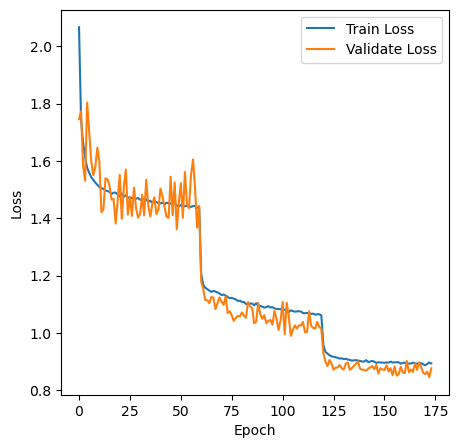

 87%|████████████████████████████████████████████████████████████████▍         | 174/200 [10:30:23<1:33:41, 216.22s/it]

Epoch:174
Time:10:33:53.322824
Loss:0.8945890005213765
Total:10000  Correct:6780  CleanAccuracy:0.6780


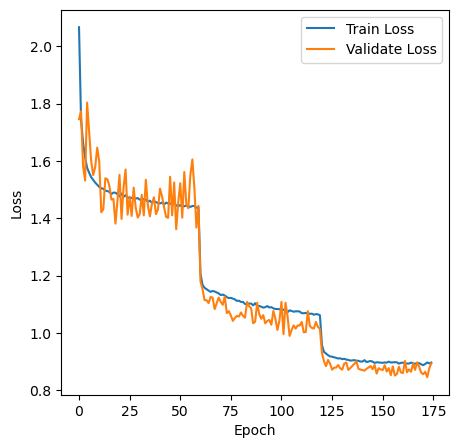

 88%|████████████████████████████████████████████████████████████████▊         | 175/200 [10:34:01<1:30:13, 216.53s/it]

Epoch:175
Time:10:37:31.160893
Loss:0.9304449460186517
Total:10000  Correct:6707  CleanAccuracy:0.6707


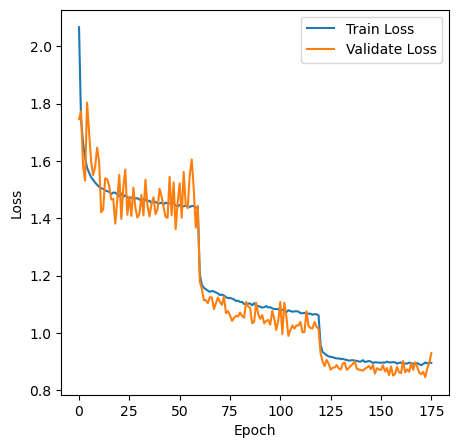

 88%|█████████████████████████████████████████████████████████████████         | 176/200 [10:37:39<1:26:46, 216.94s/it]

Epoch:176
Time:10:41:08.442340
Loss:0.8464996670953001
Total:10000  Correct:6986  CleanAccuracy:0.6986


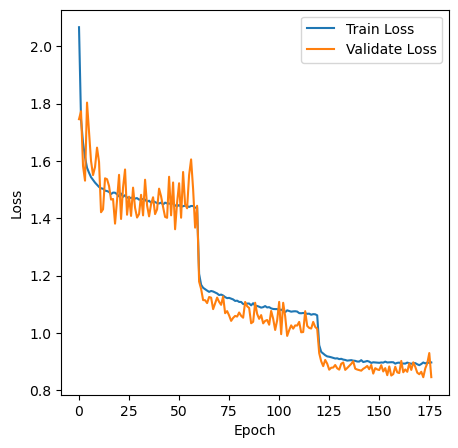

 88%|█████████████████████████████████████████████████████████████████▍        | 177/200 [10:41:16<1:23:12, 217.08s/it]

Epoch:177
Time:10:44:46.530005
Loss:0.8694744905153402
Total:10000  Correct:6916  CleanAccuracy:0.6916


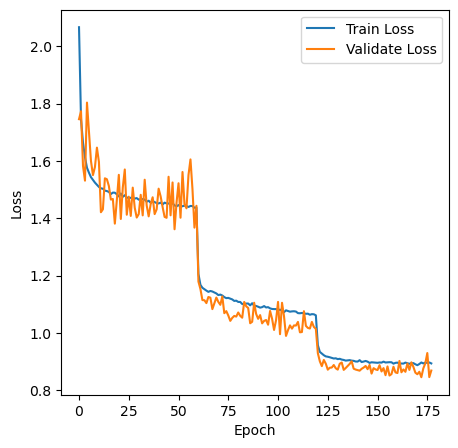

 89%|█████████████████████████████████████████████████████████████████▊        | 178/200 [10:44:54<1:19:42, 217.37s/it]

Epoch:178
Time:10:48:24.304126
Loss:0.8493168977693247
Total:10000  Correct:6979  CleanAccuracy:0.6979


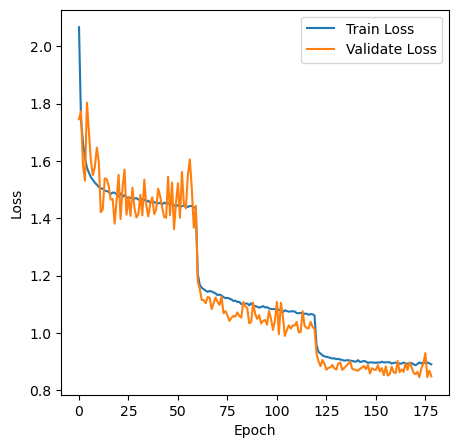

 90%|██████████████████████████████████████████████████████████████████▏       | 179/200 [10:48:31<1:16:02, 217.25s/it]

Epoch:179
Time:10:52:02.126449
Loss:0.8711216863923179
Total:10000  Correct:6882  CleanAccuracy:0.6882


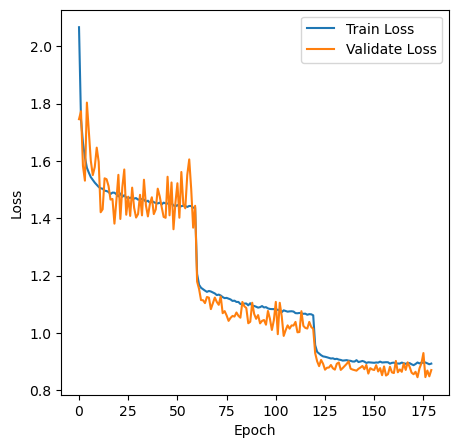

 90%|██████████████████████████████████████████████████████████████████▌       | 180/200 [10:52:09<1:12:28, 217.42s/it]

Epoch:180
Time:10:55:39.462421
Loss:0.821888168970236
Total:10000  Correct:7083  CleanAccuracy:0.7083


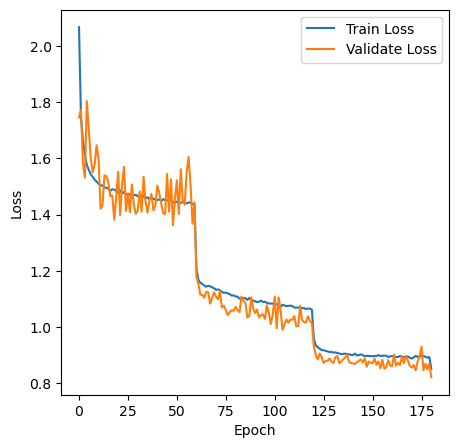

 90%|██████████████████████████████████████████████████████████████████▉       | 181/200 [10:55:47<1:08:52, 217.51s/it]

Epoch:181
Time:10:59:16.584633
Loss:0.8309202734083413
Total:10000  Correct:7049  CleanAccuracy:0.7049


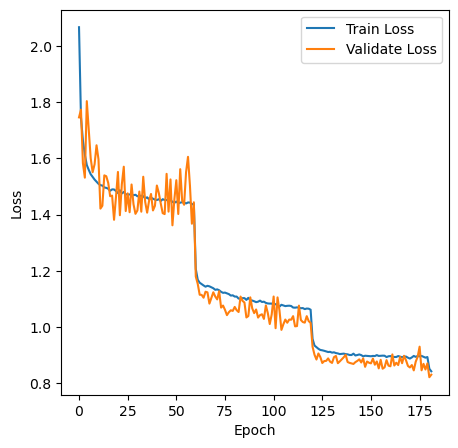

 91%|███████████████████████████████████████████████████████████████████▎      | 182/200 [10:59:24<1:05:15, 217.50s/it]

Epoch:182
Time:11:02:54.056665
Loss:0.8280577650085424
Total:10000  Correct:7081  CleanAccuracy:0.7081


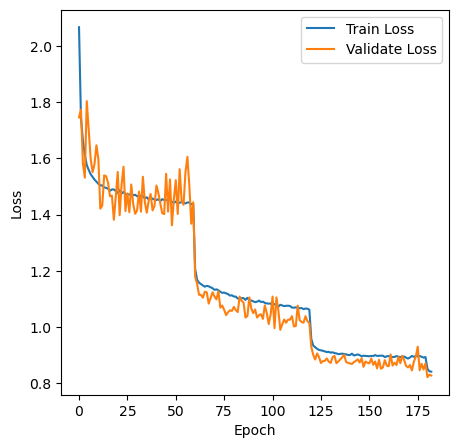

 92%|███████████████████████████████████████████████████████████████████▋      | 183/200 [11:03:02<1:01:37, 217.52s/it]

Epoch:183
Time:11:06:32.228704
Loss:0.8273340314150618
Total:10000  Correct:7069  CleanAccuracy:0.7069


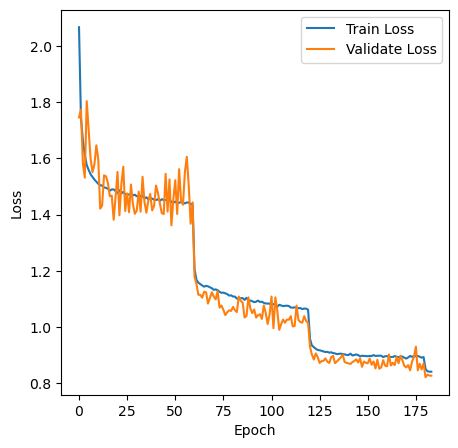

 92%|█████████████████████████████████████████████████████████████████████▉      | 184/200 [11:06:40<58:04, 217.77s/it]

Epoch:184
Time:11:10:09.371840
Loss:0.8151947238003484
Total:10000  Correct:7116  CleanAccuracy:0.7116


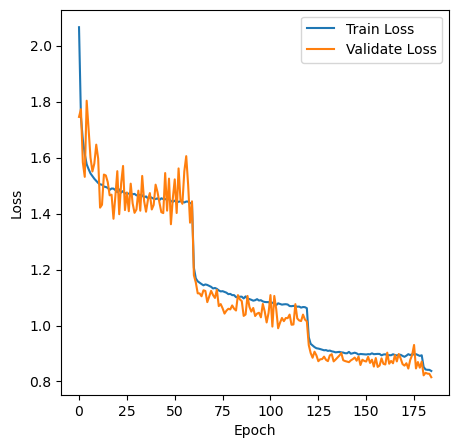

 92%|██████████████████████████████████████████████████████████████████████▎     | 185/200 [11:10:17<54:22, 217.51s/it]

Epoch:185
Time:11:13:45.700404
Loss:0.8200047860701625
Total:10000  Correct:7111  CleanAccuracy:0.7111


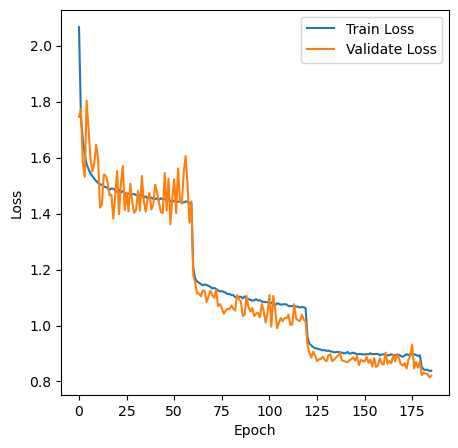

 93%|██████████████████████████████████████████████████████████████████████▋     | 186/200 [11:13:53<50:39, 217.13s/it]

Epoch:186
Time:11:17:23.266932
Loss:0.8225422870046415
Total:10000  Correct:7103  CleanAccuracy:0.7103


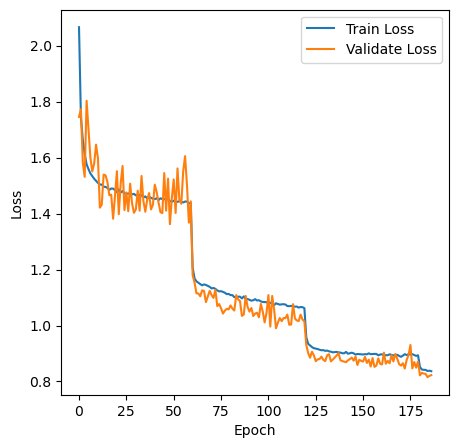

 94%|███████████████████████████████████████████████████████████████████████     | 187/200 [11:17:31<47:03, 217.22s/it]

Epoch:187
Time:11:21:00.993012
Loss:0.8283949202051559
Total:10000  Correct:7073  CleanAccuracy:0.7073


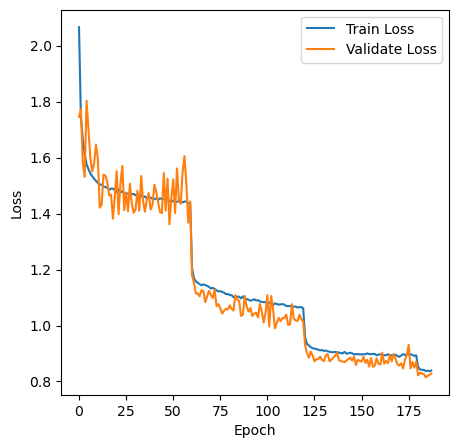

 94%|███████████████████████████████████████████████████████████████████████▍    | 188/200 [11:21:08<43:29, 217.42s/it]

Epoch:188
Time:11:24:38.796306
Loss:0.8248367779932845
Total:10000  Correct:7087  CleanAccuracy:0.7087


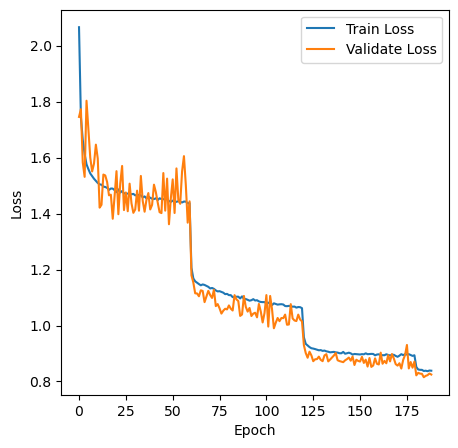

 94%|███████████████████████████████████████████████████████████████████████▊    | 189/200 [11:24:46<39:52, 217.51s/it]

Epoch:189
Time:11:28:14.701999
Loss:0.8204522722254927
Total:10000  Correct:7089  CleanAccuracy:0.7089


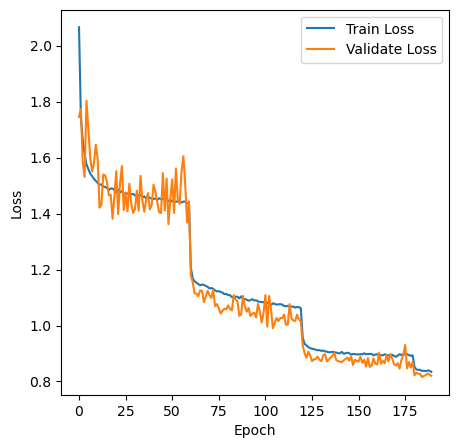

 95%|████████████████████████████████████████████████████████████████████████▏   | 190/200 [11:28:22<36:10, 217.05s/it]

Epoch:190
Time:11:31:51.458691
Loss:0.8248806509156578
Total:10000  Correct:7073  CleanAccuracy:0.7073


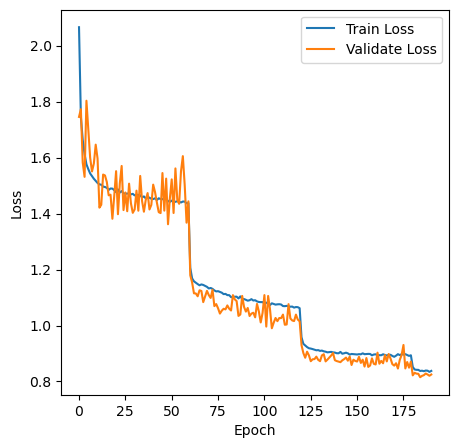

 96%|████████████████████████████████████████████████████████████████████████▌   | 191/200 [11:31:59<32:32, 216.99s/it]

Epoch:191
Time:11:35:28.781600
Loss:0.828040114416482
Total:10000  Correct:7069  CleanAccuracy:0.7069


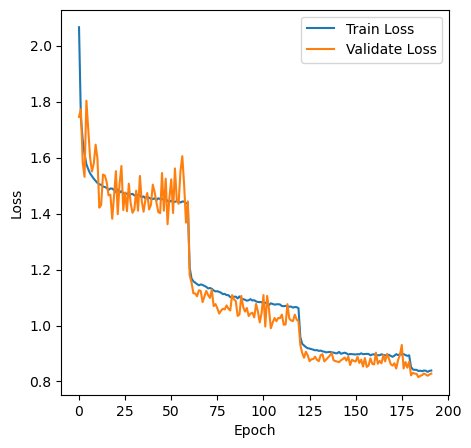

 96%|████████████████████████████████████████████████████████████████████████▉   | 192/200 [11:35:36<28:55, 216.94s/it]

Epoch:192
Time:11:39:05.855104
Loss:0.8293981492138518
Total:10000  Correct:7086  CleanAccuracy:0.7086


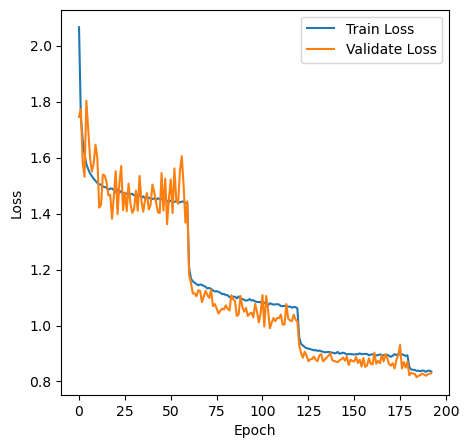

 96%|█████████████████████████████████████████████████████████████████████████▎  | 193/200 [11:39:13<25:19, 217.04s/it]

Epoch:193
Time:11:42:42.761368
Loss:0.821160366264776
Total:10000  Correct:7083  CleanAccuracy:0.7083


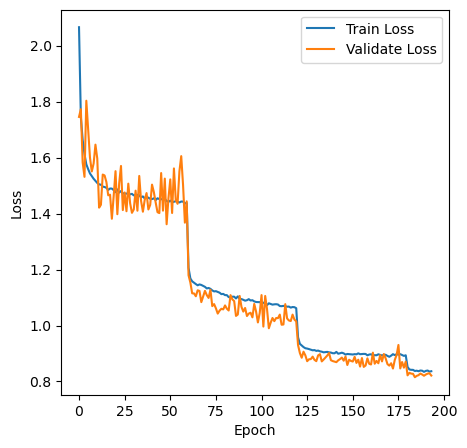

 97%|█████████████████████████████████████████████████████████████████████████▋  | 194/200 [11:42:50<21:42, 217.06s/it]

Epoch:194
Time:11:46:20.260100
Loss:0.8150418788289872
Total:10000  Correct:7130  CleanAccuracy:0.7130


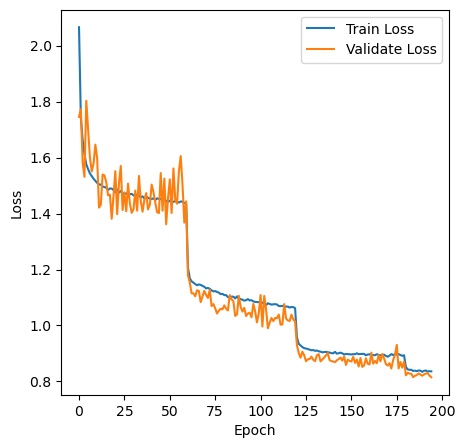

 98%|██████████████████████████████████████████████████████████████████████████  | 195/200 [11:46:28<18:06, 217.21s/it]

Epoch:195
Time:11:49:56.999127
Loss:0.8269524618078725
Total:10000  Correct:7076  CleanAccuracy:0.7076


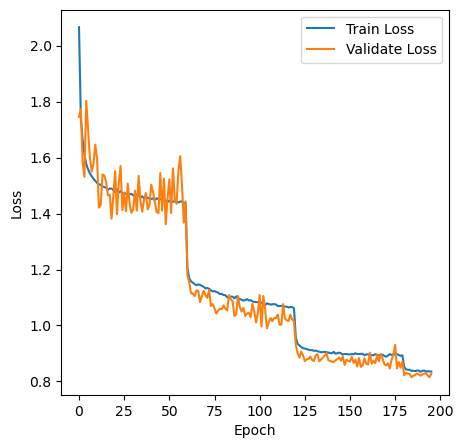

 98%|██████████████████████████████████████████████████████████████████████████▍ | 196/200 [11:50:04<14:28, 217.06s/it]

Epoch:196
Time:11:53:34.860582
Loss:0.8146115433865081
Total:10000  Correct:7132  CleanAccuracy:0.7132


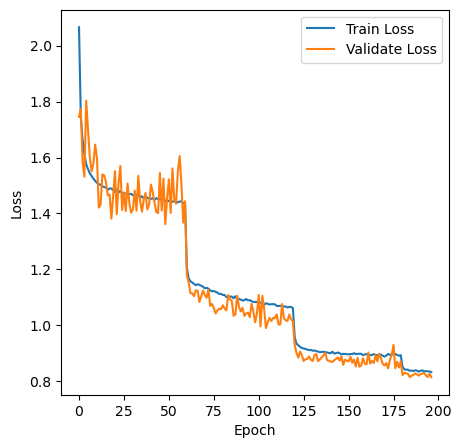

 98%|██████████████████████████████████████████████████████████████████████████▊ | 197/200 [11:53:43<10:52, 217.37s/it]

Epoch:197
Time:11:57:12.094225
Loss:0.8239525043355009
Total:10000  Correct:7075  CleanAccuracy:0.7075


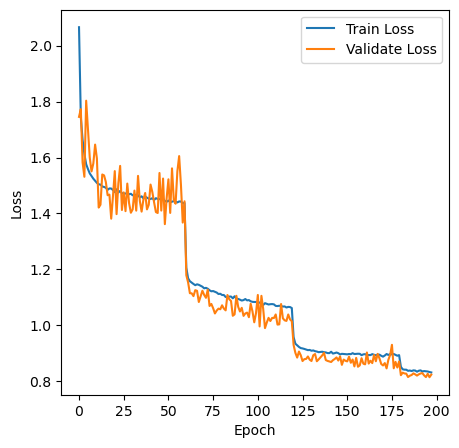

 99%|███████████████████████████████████████████████████████████████████████████▏| 198/200 [11:57:20<07:14, 217.29s/it]

Epoch:198
Time:12:00:49.417055
Loss:0.8208830157598368
Total:10000  Correct:7104  CleanAccuracy:0.7104


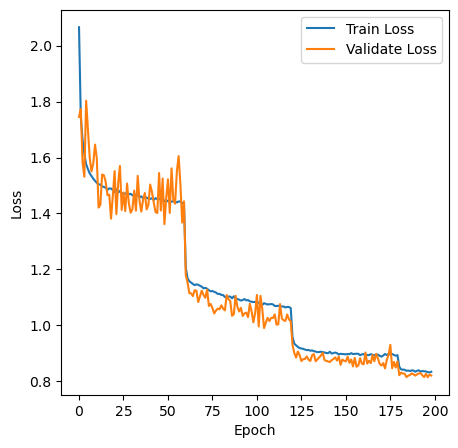

100%|███████████████████████████████████████████████████████████████████████████▌| 199/200 [12:00:57<03:37, 217.33s/it]

Epoch:199
Time:12:04:25.819656
Loss:0.8235822808437835
Total:10000  Correct:7088  CleanAccuracy:0.7088


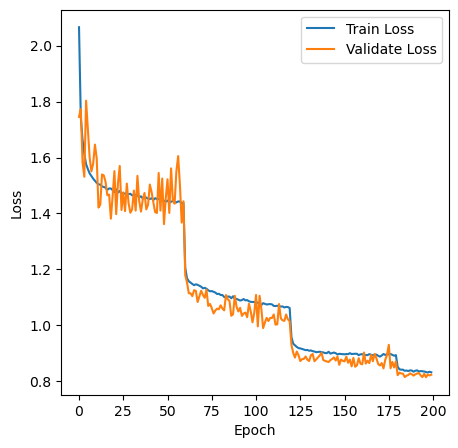

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [12:04:33<00:00, 217.37s/it]


In [9]:
train(model_device=device,
      model=net,
      model_optimizer=optimizer, 
      train_set=train_loader, 
      validate_set=test_loader
)

In [10]:
torch.cuda.empty_cache()